 RPL8 Data analysis

# Load Libraries

In [1]:
suppressPackageStartupMessages({
    library(MASS)
    library(gdata)
    library(singlecellmethods)
    library(matrixStats)
    library(data.table)
    library(viridis)
    #library(seaborn)
    library(RColorBrewer)
    library(pheatmap)
    library(Matrix)
    library(harmony)
    library(uwot)
    library(irlba)
    library(Seurat)
    library(factoextra)
    library(presto) 
    source("utils.R")
    source("misc_funcs.R")
    library(tidyverse)
    library(Biostrings)
    library(ggpubr)
    library(ggridges)
    library(ggrepel)
})


Warning message:
“package ‘data.table’ was built under R version 4.3.3”
Warning message:
“package ‘matrixStats’ was built under R version 4.3.3”
Warning message:
“package ‘Rcpp’ was built under R version 4.3.3”
Warning message:
“package ‘Biostrings’ was built under R version 4.3.3”
Warning message:
“package ‘GenomeInfoDb’ was built under R version 4.3.3”


# Import

In [2]:
exprs <- readMM("exprs_rna.mtx")
colnames(exprs) <- read.csv("colnames_exprs_rna.csv")[,2]
rownames(exprs) <- read.csv("rownames_exprs_rna.csv")[,2]

filt_exprs <- readMM("filt_exprs_rna.mtx")
colnames(filt_exprs) <- read.csv("filt_colnames_exprs_rna.csv")[,2]
rownames(filt_exprs) <- read.csv("filt_rownames_exprs_rna.csv")[,2]

counts_adt <- readMM("exprs_adt.mtx")
colnames(counts_adt) <- read.csv("colnames_exprs_adt.csv")[,2]
rownames(counts_adt) <- read.csv("rownames_exprs_adt.csv")[,2]

counts_adt_filt <- readMM("filt_exprs_adt.mtx")
colnames(counts_adt_filt) <- read.csv("filt_colnames_exprs_adt.csv")[,2]
rownames(counts_adt_filt) <- read.csv("filt_rownames_exprs_adt.csv")[,2]

meta <- read.csv("meta_rna.csv", row.names = 1)
filt_meta <- read.csv("filt_meta_rna.csv", row.names = 1)

meta_adt <- read.csv("meta_adt.csv", row.names = 1)
filt_meta_adt <- read.csv("filt_meta_adt.csv", row.names = 1)

In [3]:
FlowMatrix <- read_csv("FlowMatrixFinal.csv")

Rows: 2304 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): RPL8_Control, cell
dbl (3): FSC, SSC, PE_CD45

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
alleles_DNA <- read_csv("alleles_DNA.csv")

Rows: 53367 Columns: 18
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (13): DNA_Barcode, Well_ID, Aligned_Sequence, PlateLabel, Condition, RNA...
dbl  (5): n_deleted, n_inserted, n_mutated, #Reads, %Reads

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [6]:
plateMeta <- read_csv("RPL8Meta.csv")

Rows: 16 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): PlateLabel, Condition, RNA_Barcode, DNA_Barcode, ADT_Barcode, sgRNA...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# RPL8 DNA Analysis

In [99]:
DNAfiles = "Alleles"

In [100]:
#Alleles Function for Import - Updated- Fixed Naming to Automate and Changed to Capture the top 10 alleles per cell. 
AllelesFunction <- 
function (filepath, number_of_alleles = 10, folder_name="Alleles") #Filepath is the folder with all the allele tables. 
{
    files <- list.files(path = filepath, pattern = ".txt$", full.names = T, 
        recursive = T) 
    
    matrix <- suppressMessages({
        suppressWarnings({
            lapply(files, read_tsv, n_max = number_of_alleles, col_select = c(1, 
                5, 6, 7, 8, 9))
        })
    })
    names(matrix) <- lapply(files, FUN = 
      function(x) { 
          paste0(substr(x, str_locate(x, paste0(folder_name, "/"))[2]+1, str_locate(x, "/CRISPRessoBatch_on_batch")[1]-1), #modified for Full
                            "_", 
                             substr(x, str_locate(x, "CRISPResso_on_([A-Z])(\\d)")[2]-1, str_locate(x, "/Alleles_frequency_table.txt")[1]-1))})
    
    matrix <- bind_rows(matrix, .id = "Plate_Well")
    return(matrix)
}

In [105]:
#Upload all Alleles
alleles_DNA <- AllelesFunction(DNAfiles, folder_name="Alleles")

In [106]:
# Add Meta Data
alleles_DNA<- alleles_DNA %>% separate(Plate_Well, into = c("DNA_Barcode", "Well_ID")) %>% 
    inner_join(plateMeta) %>% inner_join(read_csv("RNA_ADT_Barcodes.csv")) %>% 
    mutate(cell = paste0(RNA_cell, "_", RNA_Barcode))

Joining with `by = join_by(DNA_Barcode)`
Rows: 384 Columns: 2
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (2): Well_ID, RNA_cell

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(Well_ID)`


In [108]:
write_csv(alleles_DNA, "alleles_DNA.csv")

In [9]:
# Jump in

In [8]:
alleles_DNA <- filter(alleles_DNA, Condition == "RPL8CellLine")

In [11]:
alleles_DNA$Reference <- 
"TGACCTACCTGTTCACCAGCGCGGCCGAAAGAGGAAACACGGCGTCAGCGAGCGGCCTTATCTTCCGGGGCGGGGCCCAGGGCCGCGACACCTTCCGGGCGCGCCACGGCCAGCCTAGCG"

In [ ]:
## Update DNA calling. 

In [13]:
source("/Users/bagtq9/Desktop/Box Sync/2017 - Raychaudhuri Lab/Lab Documents/scRNA-DNA GSK/Experiments/UpdatedExperiments/DNA_filtering_Functions.R")

In [14]:
alleles_DNA <- alleles_DNA %>% rename(DNA_Barcode = "Barcode_DNA")

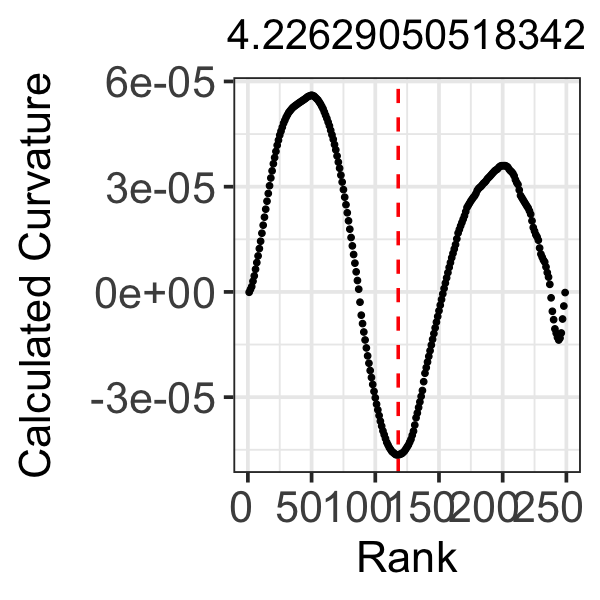

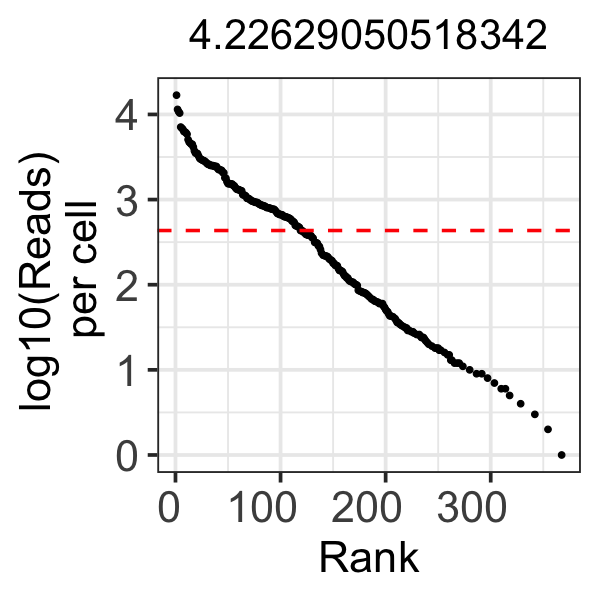

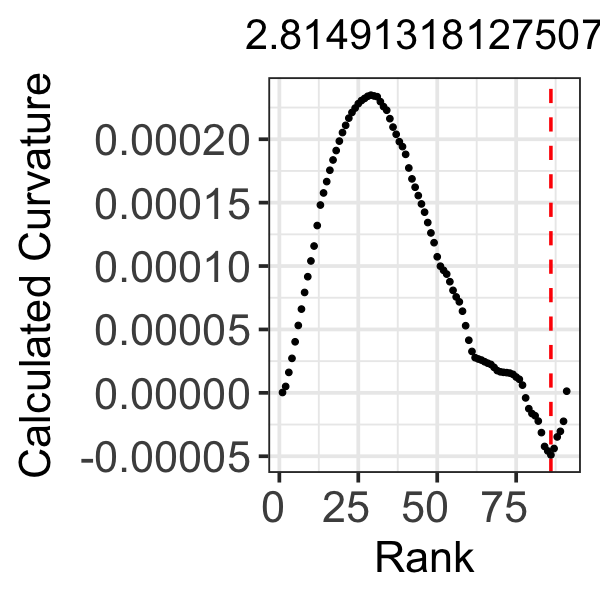

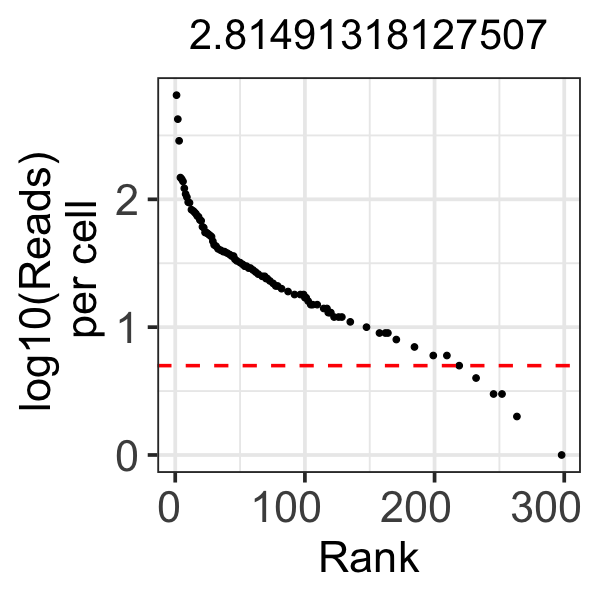

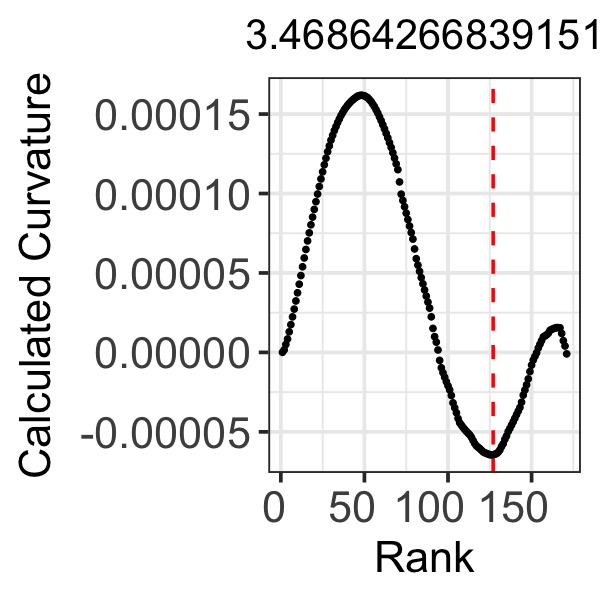

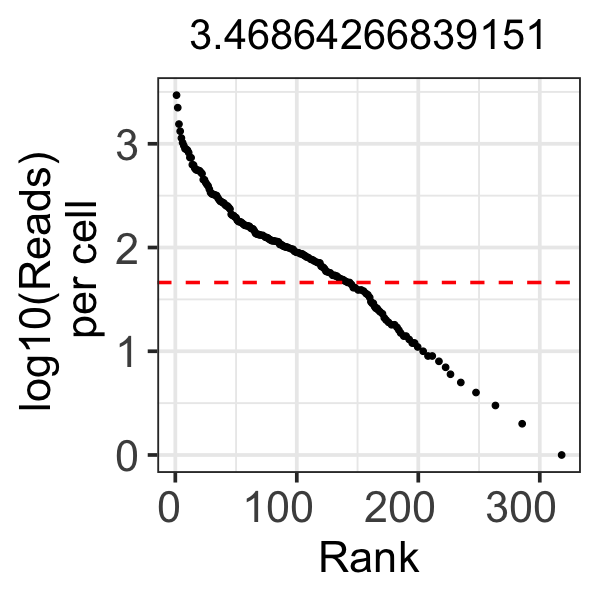

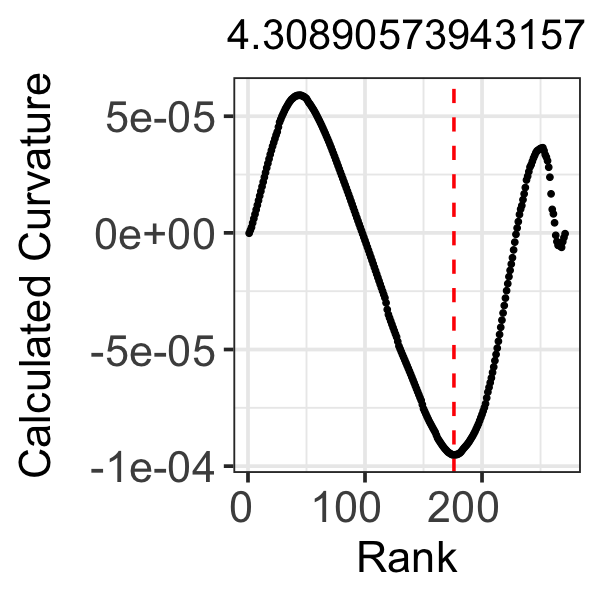

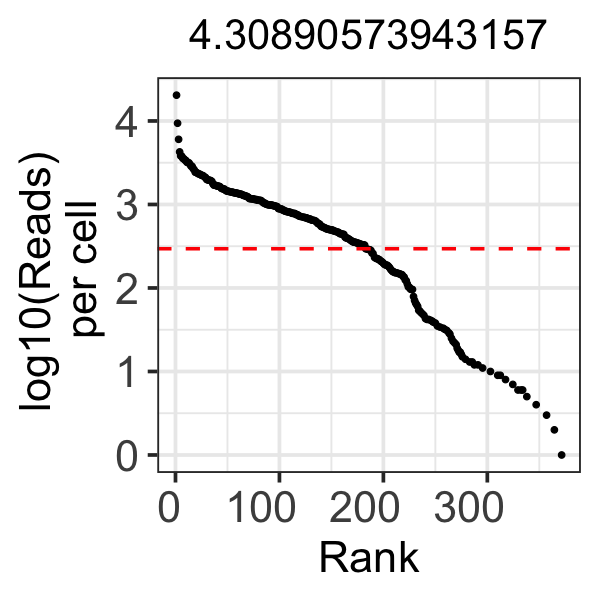

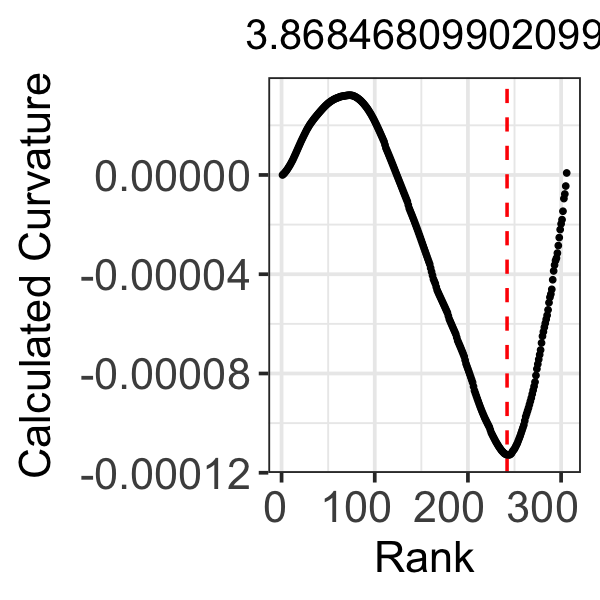

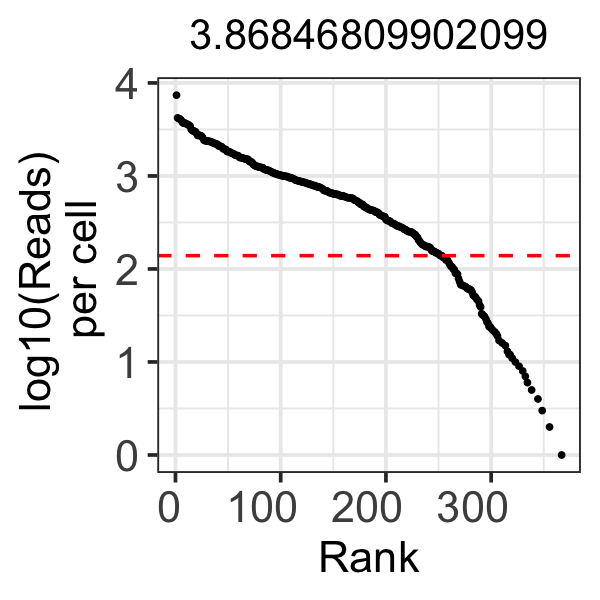

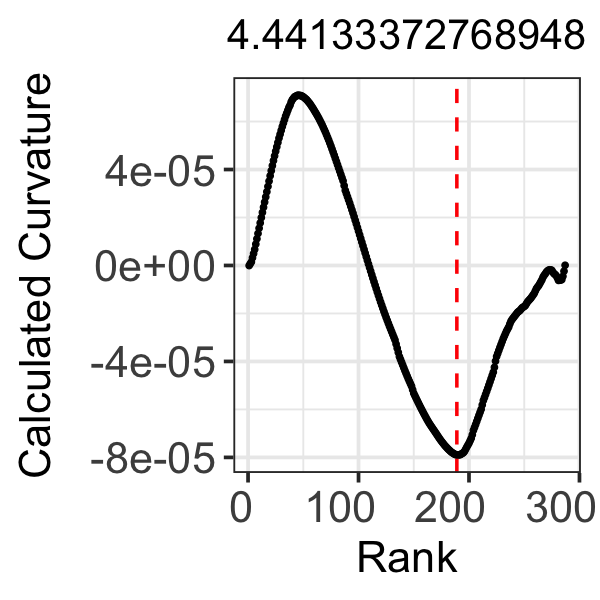

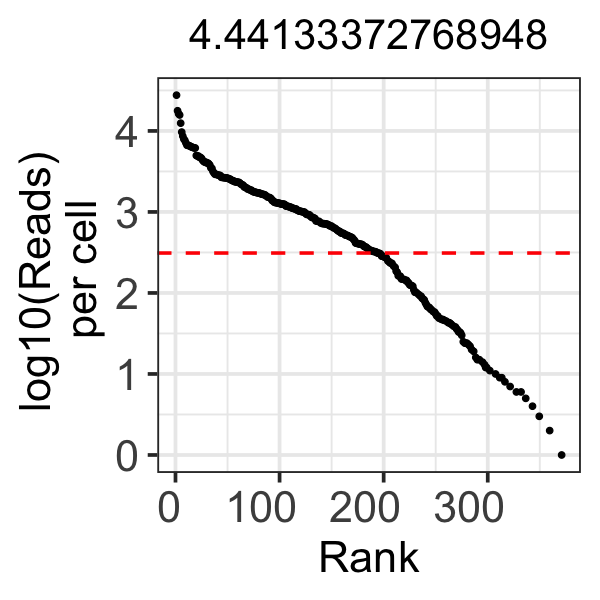

In [62]:
fig.size(5,5)
alleles_DNA_filt <- Filtering_Cells_Read(alleles_DNA)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


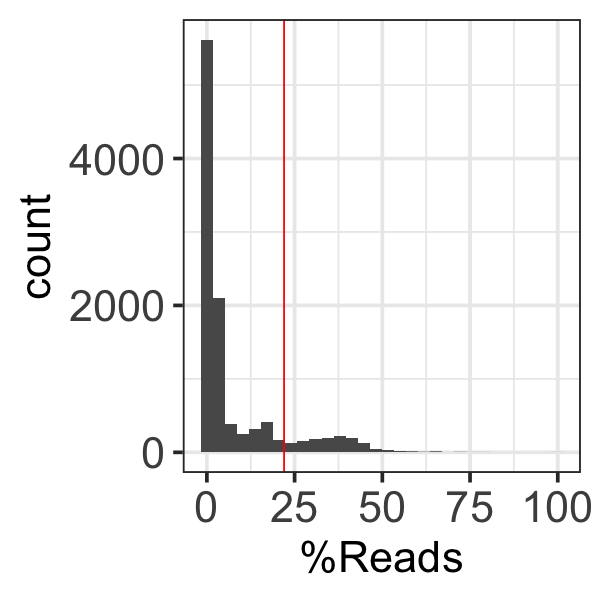

In [63]:
#Define a cutoff
alleles_DNA_filt %>% ggplot(aes(`%Reads`)) + geom_histogram() + theme_gy() + geom_vline(xintercept = 22, color = "red")

In [65]:
alleles_DNA_filt <- alleles_DNA_filt %>% Filtering_Alleles(cutoff=22)

In [66]:
#Fix length from P7
alleles_DNA_filt<- alleles_DNA_filt %>% 
    mutate("Aligned_Sequence" = str_trunc(Aligned_Sequence, 50, "right",ellipsis = "" )) %>% 
    mutate("Reference"= str_trunc(Reference, 50, "right", ellipsis = "")) %>% 
    mutate("Aligned_Sequence" = str_trunc(Aligned_Sequence, 35, "left",ellipsis = "" )) %>% 
    mutate("Reference"= str_trunc(Reference, 35, "left", ellipsis = ""))

In [67]:
alleles_DNA_filt_gen <- Genotyping_Cells(alleles_DNA_filt)

In [69]:
## Remove alleles found in less than 5 cells. 
alleles_DNA_filt <- alleles_DNA_filt  %>% add_count(name = "AlleleCount", Aligned_Sequence) %>% filter(AlleleCount >5)

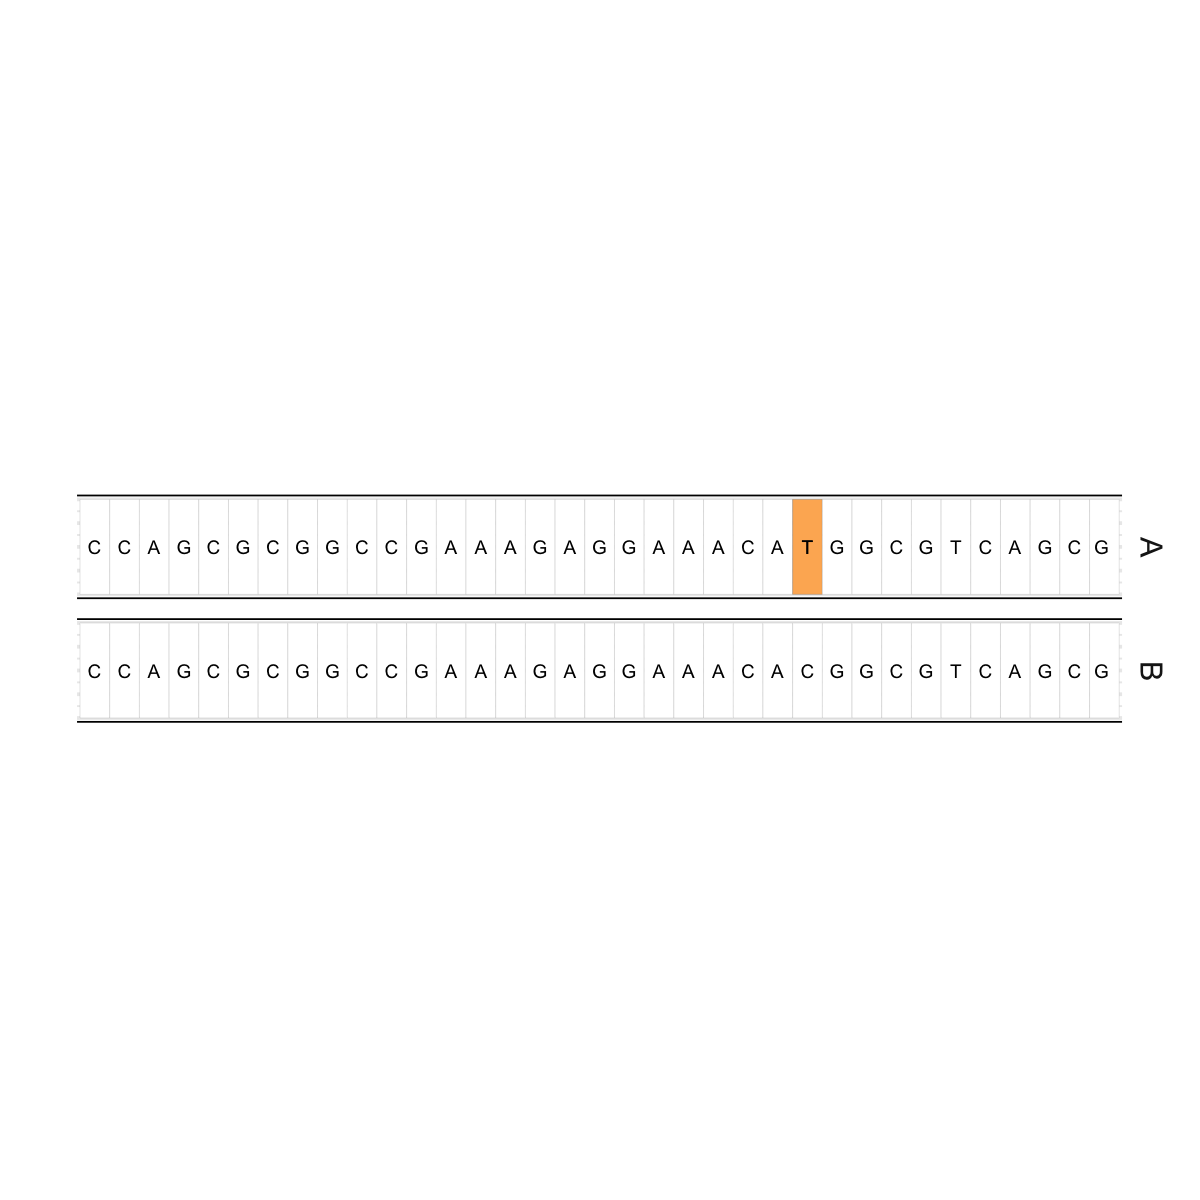

In [70]:
alleles_DNA_filt %>% Plotting_Alleles

In [71]:
alleles_DNA_filt_gen <- Genotyping_Cells(alleles_DNA_filt)

In [72]:
alleles_DNA_filt_gen$AllelicGenotype %>% table

.
  A  AB   B 
773 225  89 

Joining with `by = join_by(plate_well)`
Joining with `by = join_by(cell)`


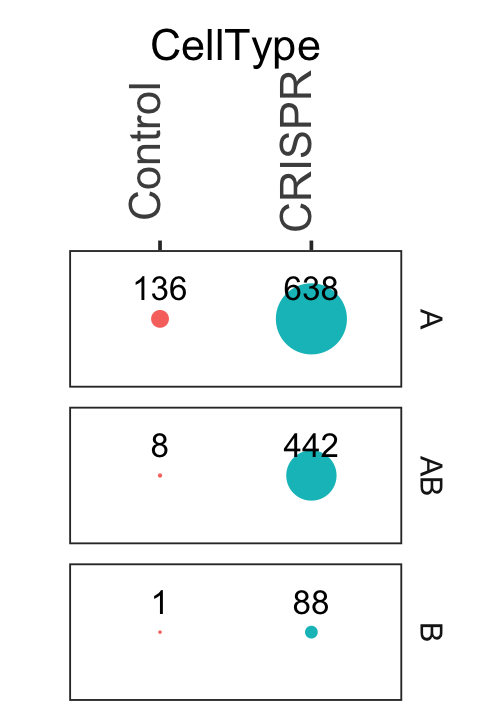

In [74]:
test2 <- alleles_DNA_filt_gen %>% inner_join(alleles_DNA_filt) %>% inner_join(FlowMatrix) 


#Defineplotting Order
order <- test2$AllelicGenotype %>% table %>% as_data_frame %>% arrange(`n`)
order <- as.character(order$`.`)


fig.size(6,4)
g <- 

table(test2$AllelicGenotype,test2$RPL8_Control) %>% 
as.data.frame() %>% dplyr::rename(CellType = Var2, genotype = Var1) %>% 
na.omit %>% filter(Freq != 0) %>% {
    
    ggplot(., aes(CellType,fill=CellType,
                   size = Freq)) +
      geom_point(aes(y = 0),shape = 21, stroke = 0) +
      #geom_hline(yintercept = seq(.5, 4.5, 1), size = .2) +
  scale_x_discrete(position = "top") +
  scale_radius(range = c(1,20)) +
    geom_text(aes(y = 0, label = Freq), size =7, vjust = -0.8)+
  theme_gy() +
  theme(legend.position = "none", 
        panel.grid.major = element_blank(),
        legend.text = element_text(size = 8),
        legend.title = element_text(size = 8), 
       axis.text.x = element_text(angle = 90)) + 
    ylab("") + 
    scale_y_discrete(expand = c(0.1,0.5)) + 
    facet_grid(factor((genotype))~ 
               .) + 
    theme(
  strip.background = element_blank(),
  #strip.text.x = element_blank(), 
    #panel.border=element_blank(), 
   # strip.text.y = element_blank()  
        ) #+scale_fill_manual(values = c("2"='#8DA0CB',
           #                       "1" = '#66C2A5',
            #                      "0"='#FC8D62'))
    
} 
plot(g)
suppressWarnings({ 
    ggsave(g, filename = "RPL8_Genotypes.png", device = "png", dpi = 300, width = 4, height = 6)
    })


In [189]:
#Label Dosage
alleles_DNA_filt_gen <- mutate(alleles_DNA_filt_gen, 
                               "Dosage" = ifelse(AllelicGenotype == "A", 2, 
                                               ifelse(AllelicGenotype == "B", 0, 
                                                     ifelse(AllelicGenotype == "AB", 1, NA))))

# QC

## RNA QC

In [81]:
nUMI = colSums(exprs)
nGenes = colSums(exprs > 0)
pctMito = colSums(exprs[rownames(exprs)[rownames(exprs) %>% startsWith('MT-')], ])/nUMI
qc_df = data.frame(nUMI = nUMI, nGenes = nGenes, pctMito = pctMito)

# meta = cbind(meta, qc_df[rownames(meta), ])

In [82]:
nCells = rowSums(exprs > 0)
gene_qc = data.frame(nCells = nCells %>% sort %>% rev, rank = seq(1, length(nCells)))

## ADT QC

In [83]:
nUMI_ADT = colSums(counts_adt_filt)
nGenes_ADT = colSums(counts_adt_filt > 0)
qc_df_ADT = data.frame(nUMI = nUMI_ADT, nGenes = nGenes_ADT)

# Merge Modalities

In [84]:
ADTcells <- filt_meta_adt %>% with(cell)

In [85]:
RNAcells <- filt_meta %>% with(cell)

In [86]:
DNAcells <- test2 %>% with(cell)

In [87]:
Flowcells <- FlowMatrix %>% with(cell) 

In [88]:
cells <- intersect(ADTcells, RNAcells)  %>% intersect(DNAcells) %>% intersect(Flowcells)

In [89]:
cells %>% length

[1] 970

In [90]:
norm_filt_exprs <- normalizeData(filt_exprs, method = "log")

'as(<dgTMatrix>, "dgCMatrix")' is deprecated.
Use 'as(., "CsparseMatrix")' instead.
See help("Deprecated") and help("Matrix-deprecated").



# Pre-process expression data

In [47]:
### Pre-process based on metadata conditions (only overlapping DNA/RNA/ADt)

In [92]:
scale_exprs = process_rna(filt_exprs[,cells], filt_meta[cells,])

In [93]:
scale_exprs %>% dim

[1] 3000  970

In [98]:
scale_adt = process_adt(counts_adt_filt[,cells], filt_meta_adt[cells,])

In [99]:
scale_adt %>% dim

[1] 154 970

# UMAPs

Warning message:
“Warning: The parameters do_pca and npcs are deprecated. They will be ignored for this function call and please remove parameters do_pca and npcs and pass to harmony cell_embeddings directly.
This warning is displayed once per session.”
Warning message:
“Warning: The parameter max.iter.harmony is replaced with parameter max_iter. It will be ignored for this function call and please use parameter max_iter in future function calls.
This warning is displayed once per session.”
Warning message:
“Warning: The parameter max.iter.cluster is deprecated. It will be ignored for this function call and please remove parameter max.iter.cluster in future function calls. Advanced users can set value of parameter max.iter.cluster by using parameter .options and function harmony_options().
This warning is displayed once per session.”
Warning message:
“Warning: The parameter epsilon.cluster is deprecated. It will be ignored for this function call and please remove parameter epsilon.clus

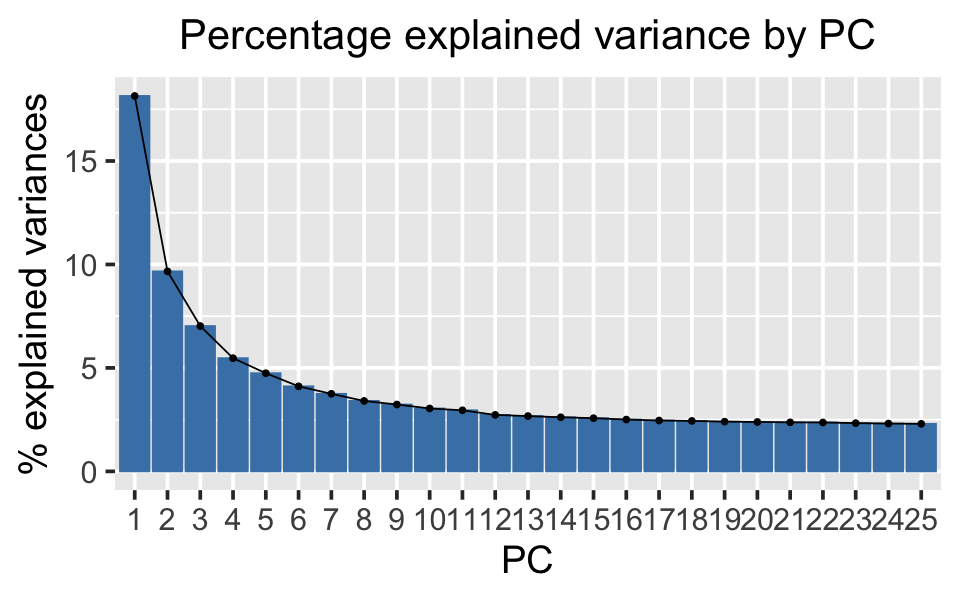

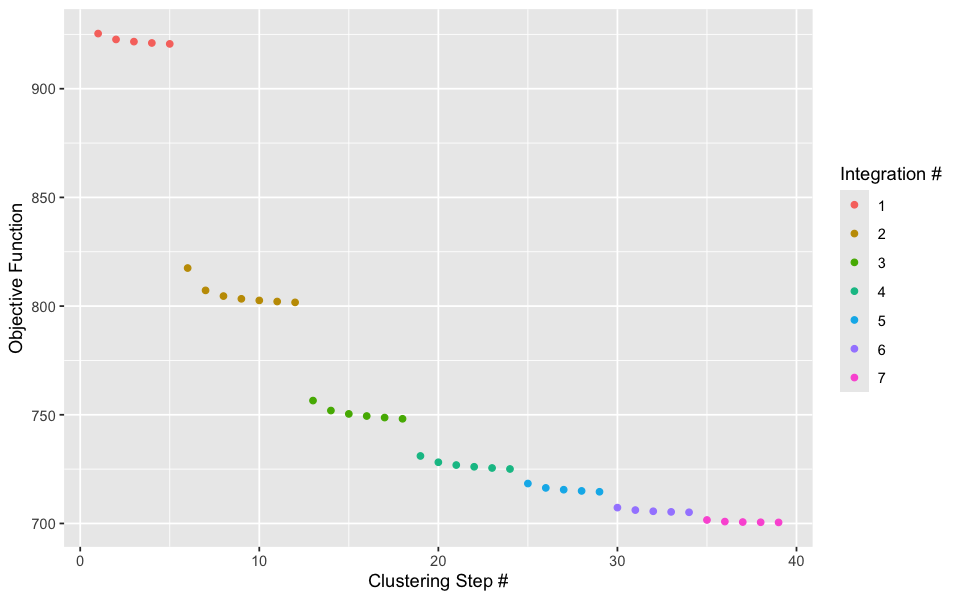

In [94]:
set.seed = 123
meta_umap = pca_umap(scale_exprs, filt_meta[cells,], harmony_var = 'PlateLabel')

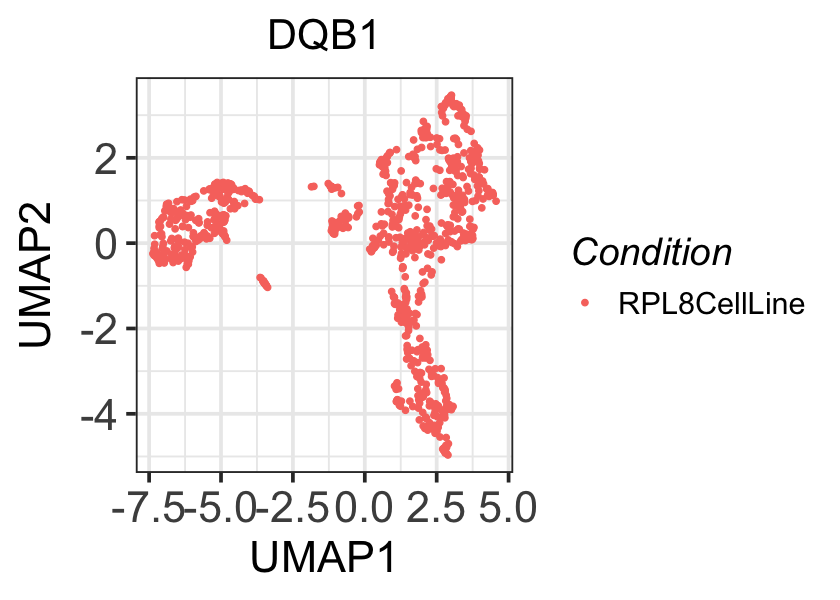

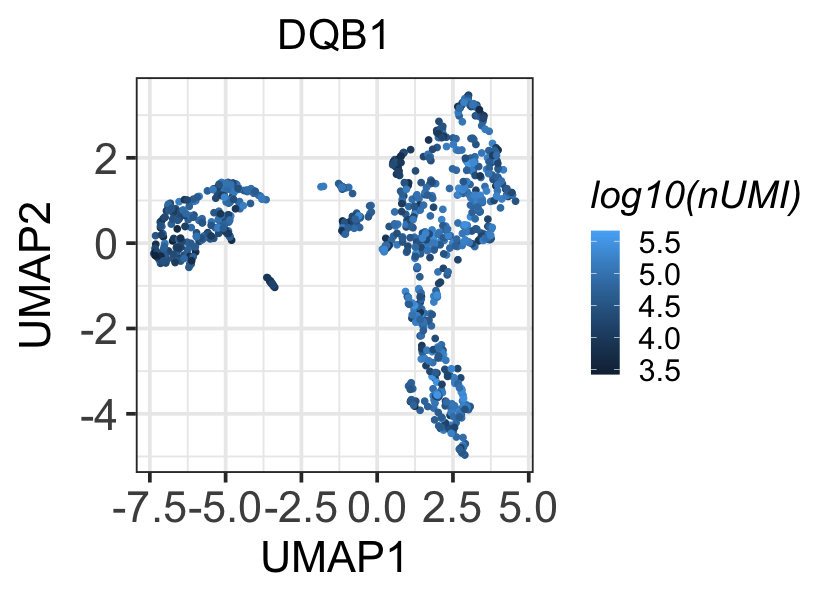

In [95]:
fig.size(5, 7)
ggplot(meta_umap %>% sample_n(nrow(meta_umap)))+
    geom_point(aes(x = UMAP1, y = UMAP2, col = Condition))+
    theme_gy()+
    ggtitle('DQB1')
fig.size(5, 7)
ggplot(meta_umap %>% sample_n(nrow(meta_umap)))+
    geom_point(aes(x = UMAP1, y = UMAP2, col = log10(nUMI)))+
    theme_gy()+
    ggtitle('DQB1')

## RPL8 ADT

Transposing data matrix

Initializing state using k-means centroids initialization

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony converged after 5 iterations

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’



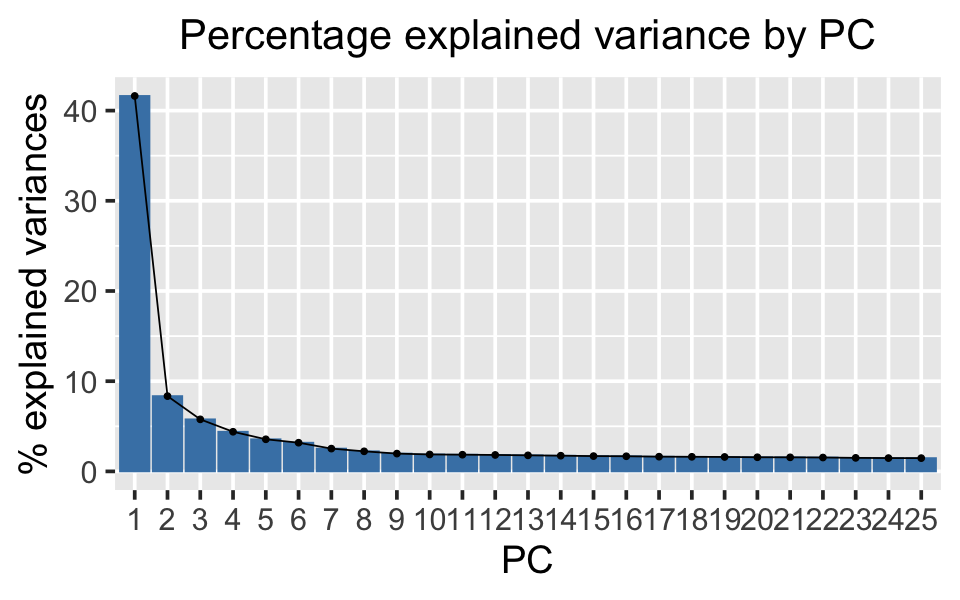

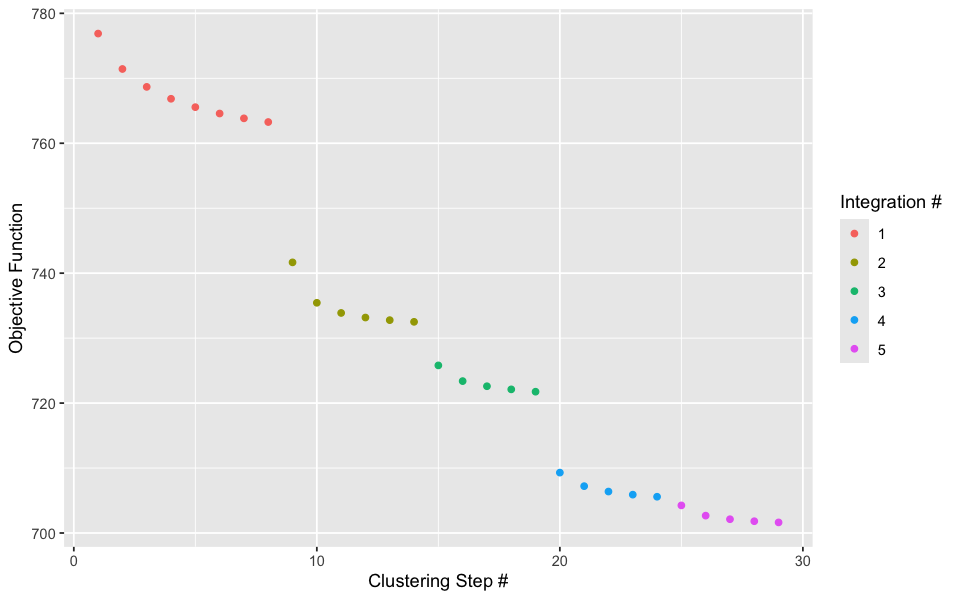

In [100]:
meta_umap_adt = pca_umap(scale_adt, filt_meta_adt[cells,],
                            harmony_var = 'PlateLabel')

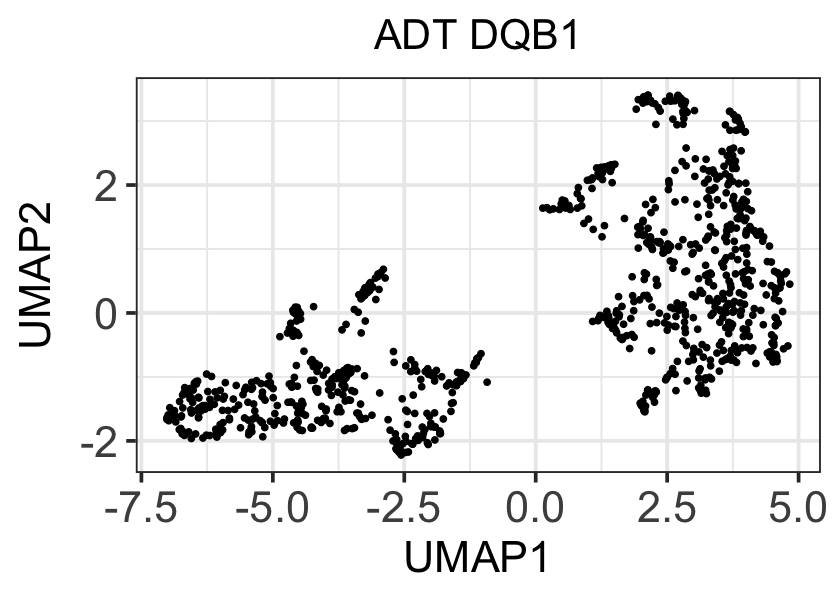

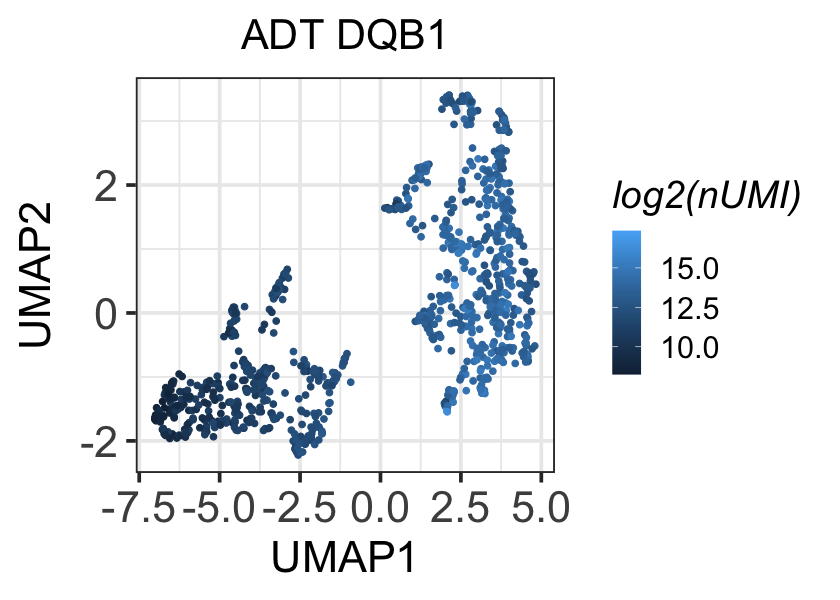

In [101]:
fig.size(5, 7)
ggplot(meta_umap_adt %>% sample_n(nrow(meta_umap_adt)))+
    geom_point(aes(x = UMAP1, y = UMAP2))+
    theme_gy()+
    ggtitle('ADT DQB1')

fig.size(5, 7)
ggplot(meta_umap_adt %>% sample_n(nrow(meta_umap_adt)))+
    geom_point(aes(x = UMAP1, y = UMAP2, col = log2(nUMI)))+
    theme_gy()+
    ggtitle('ADT DQB1')

# Clustering + DGE

## DQB1

In [102]:
meta_umap.clust = do_cluster(meta_umap, resolution_list = seq(0.05, 0.5, 0.05))

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 970
Number of edges: 33551

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9569
Number of communities: 2
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 970
Number of edges: 33551

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9263
Number of communities: 2
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 970
Number of edges: 33551

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8964
Number of communities: 2
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 970
Number of edges: 33551

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8742
Number of communities: 3
Elapsed time: 0 seconds
Modularity Optimizer version

In [103]:
table(meta_umap.clust$`res.0.1`)


  0   1 
713 257 

In [104]:
meta_umap.clust$cluster = meta_umap.clust$`res.0.1`

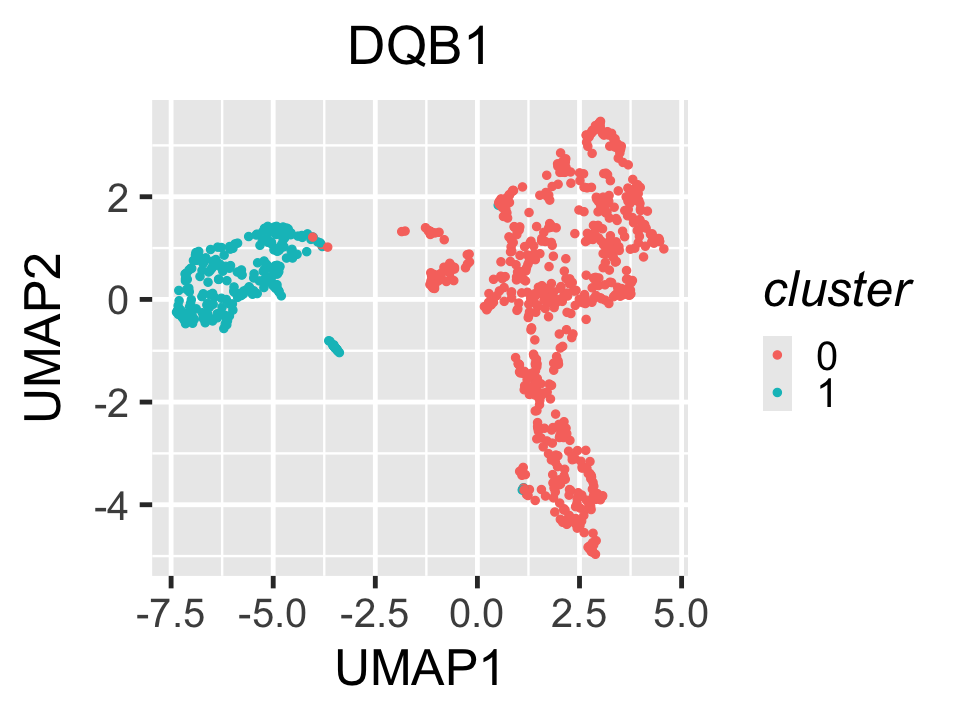

In [105]:
fig.size(6, 8)
ggplot(meta_umap.clust[sample(rownames(meta_umap.clust)), ])+
    geom_point(aes(x= UMAP1, y = UMAP2, col = cluster), size = 2)+
    theme_g(30)+
    ggtitle('DQB1')

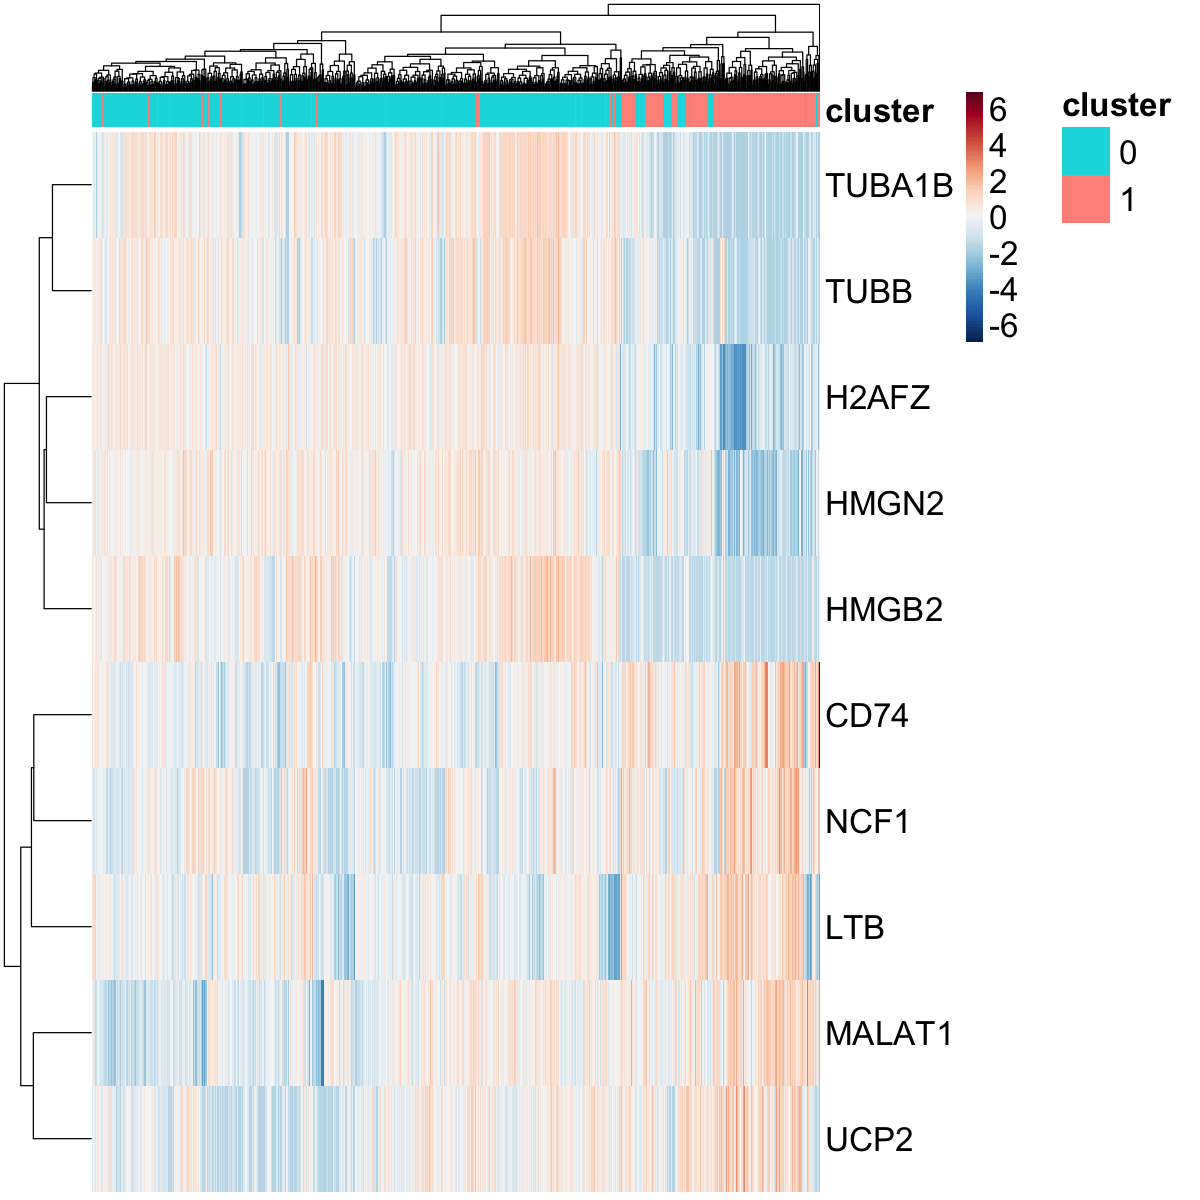

In [106]:
dge = wilcoxauc(scale_exprs, meta_umap.clust$cluster)

var_genes = top_markers(dge, 10) %>% head(5) %>% select(-rank) %>% 
                        unlist %>% unique 
cmax = abs(scale_exprs[var_genes, ]) %>% unlist %>% max #%>% quantile(.995)

# Data frame with column annotations.
mat_col <- data.frame(cluster = meta_umap.clust$cluster)
rownames(mat_col) <- rownames(meta_umap.clust)


# Sort dendogram
mat_cluster_cols <- hclust(dist(t(scale_exprs[var_genes, ])))
mat_cluster_cols <- sort_hclust(mat_cluster_cols)
mat_cluster_rows <- sort_hclust(hclust(dist(scale_exprs[var_genes, ])))

fig.size(10, 10)
pheatmap(scale_exprs[c(var_genes),],
         breaks = seq(-cmax, cmax, length.out = 100),
        color = colorRampPalette(brewer.pal(11, "RdBu"))(100) %>% rev,
        show_colnames = FALSE,
         annotation_col = mat_col, fontsize = 20,
       cluster_cols= mat_cluster_cols,
        cluster_rows = mat_cluster_rows,

        )

### ADT

In [107]:
meta_umap_adt.clust = do_cluster(meta_umap_adt, resolution_list = seq(0.1, 1, 0.1))

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 970
Number of edges: 36050

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9266
Number of communities: 2
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 970
Number of edges: 36050

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8754
Number of communities: 2
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 970
Number of edges: 36050

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8245
Number of communities: 3
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 970
Number of edges: 36050

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7860
Number of communities: 4
Elapsed time: 0 seconds
Modularity Optimizer version

In [108]:
table(meta_umap_adt.clust$'res.0.1')


  0   1 
563 407 

In [109]:
meta_umap_adt.clust$cluster = meta_umap_adt.clust$`res.0.1`

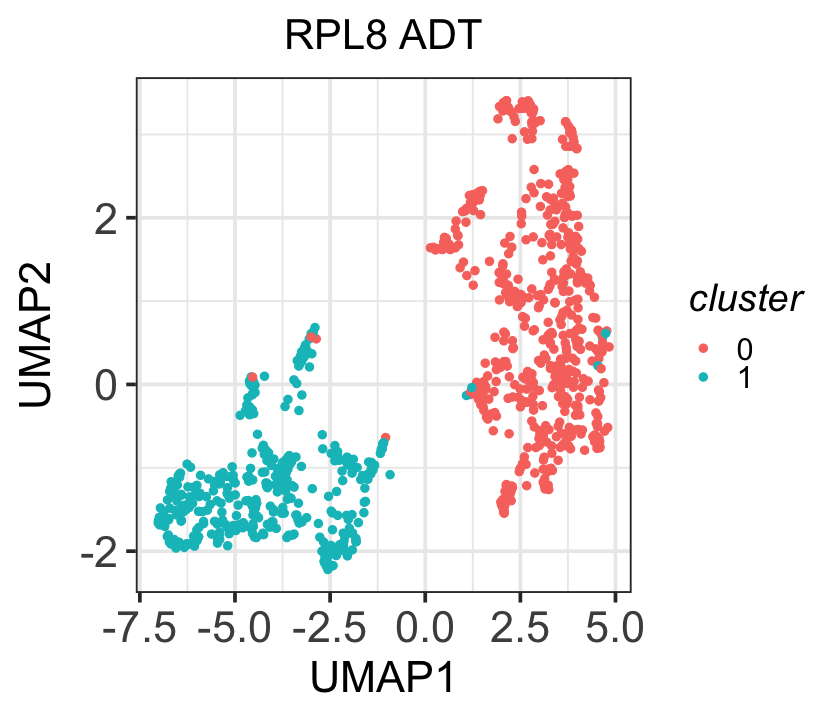

In [110]:
fig.size(6, 7)
ggplot(meta_umap_adt.clust[sample(rownames(meta_umap_adt.clust)), ])+
    geom_point(aes(x= UMAP1, y = UMAP2, col = cluster), size = 2)+
    theme_g(30)+
    ggtitle('RPL8 ADT') + theme_gy()

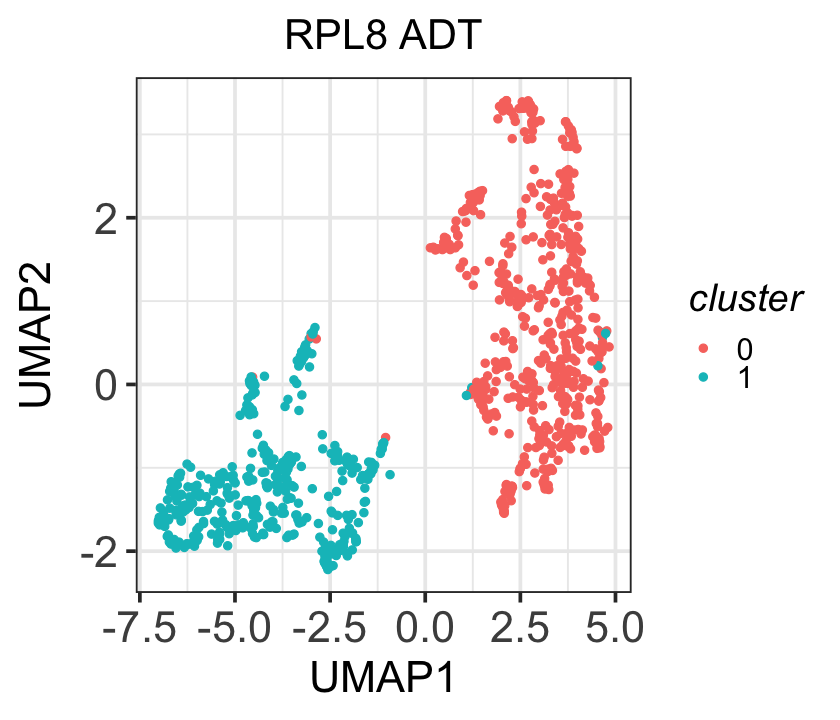

In [111]:
fig.size(6, 7)
ggplot(meta_umap_adt.clust[sample(rownames(meta_umap_adt.clust)), ])+
    geom_point(aes(x= UMAP1, y = UMAP2, col = cluster), size = 2)+
    theme_g(30)+
    ggtitle('RPL8 ADT') + theme_gy()

In [112]:
plot_exprs(norm_exprs, meta_umap.clust, c("RPL8")) & theme_gy()

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 't': object 'norm_exprs' not found


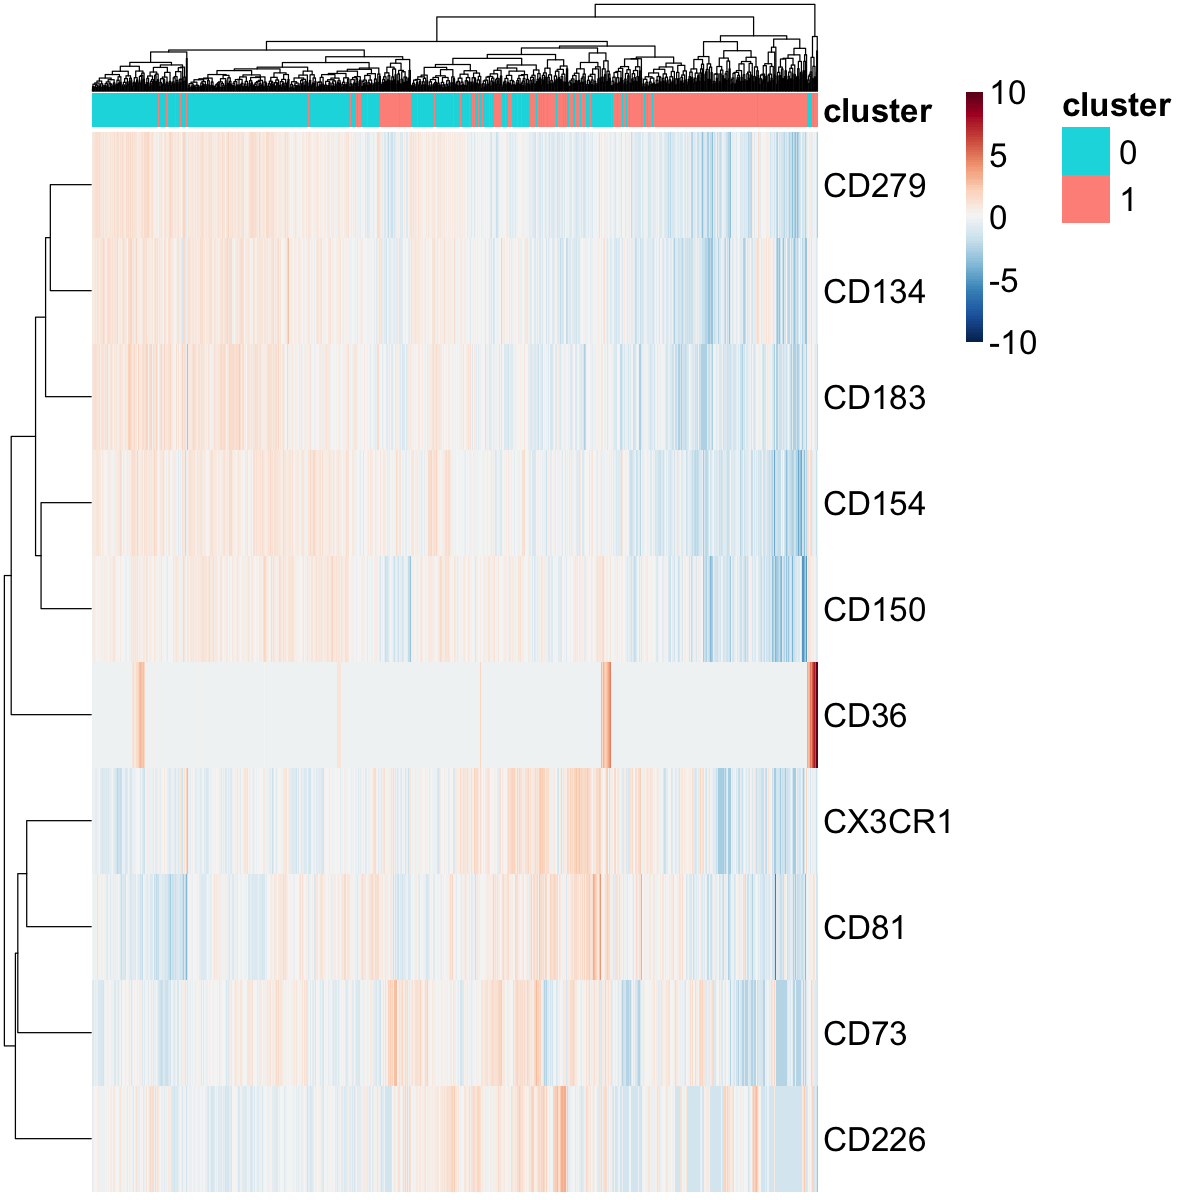

In [113]:
dge = wilcoxauc(scale_adt, meta_umap_adt.clust$cluster)

var_genes = top_markers(dge, 10) %>% head(5) %>% select(-rank) %>% 
                        unlist %>% unique 
cmax = abs(scale_adt[var_genes, ]) %>% unlist %>% max #%>% quantile(.995)

# Data frame with column annotations.
mat_col <- data.frame(cluster = meta_umap_adt.clust$cluster)
rownames(mat_col) <- rownames(meta_umap_adt.clust)


# Sort dendogram
mat_cluster_cols <- hclust(dist(t(scale_adt[var_genes, ])))
mat_cluster_cols <- sort_hclust(mat_cluster_cols)
mat_cluster_rows <- sort_hclust(hclust(dist(scale_adt[var_genes, ])))

fig.size(10, 10)
pheatmap(scale_adt[c(var_genes),],
         breaks = seq(-cmax, cmax, length.out = 100),
        color = colorRampPalette(brewer.pal(11, "RdBu"))(100) %>% rev,
        show_colnames = FALSE,
         annotation_col = mat_col, fontsize = 20,
       cluster_cols= mat_cluster_cols,
        cluster_rows = mat_cluster_rows,

        )

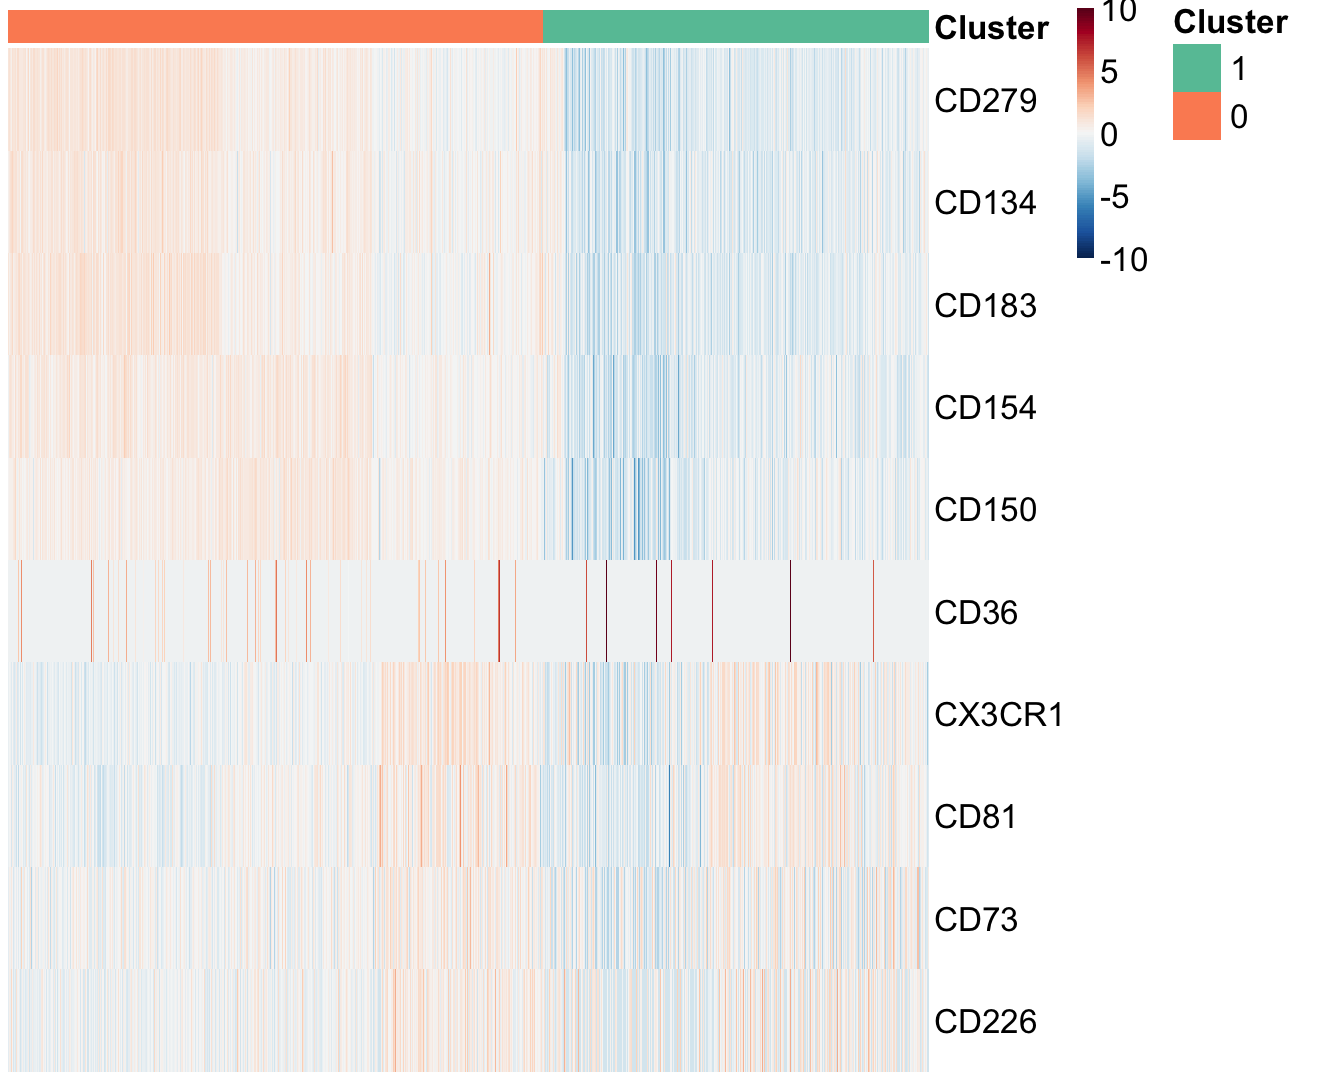

In [116]:
## UpdatedHeatmap

meta <- arrange(meta_umap_adt.clust, cluster)
df <- scale_adt[,meta$cell]

   
    dge = wilcoxauc(df, meta$cluster)
    var_genes = top_markers(dge, 5) %>% head(5) %>% select(-rank) %>% unlist %>% unique
    cmax = abs(df[var_genes, ]) %>% unlist %>% max
    
    mat_col <- data.frame(Cluster = meta$cluster)
    rownames(mat_col) <- rownames(meta)
    
    mat_colors <- list(Cluster = c(
        "1" = "#66C2A5", 
        "0" = "#FC8D62" 
        #"2" = "#8DA0CB"
    ))
    
    mat_cluster_cols <- hclust(dist(t(df[var_genes, ])))
    mat_cluster_cols <- sort_hclust(mat_cluster_cols)
    mat_cluster_rows <- sort_hclust(hclust(dist(df[var_genes, 
        ])))
   
fig.size(9, 11)
    pheatmap(df[var_genes, ],
            # main = "Scaled TPM PTEN", 
             breaks = seq(-cmax, cmax, length.out = 100), 
             color = colorRampPalette(brewer.pal(11, "RdBu"))(100) %>% rev, 
             show_colnames = FALSE, 
             annotation_col = mat_col, 
             annotation_colors = mat_colors,
            fontsize = 20, 
             cluster_cols = F, 
             cluster_rows = mat_cluster_rows, 
             treeheight_row = 0, 
            treeheight_col = 0, 
            )

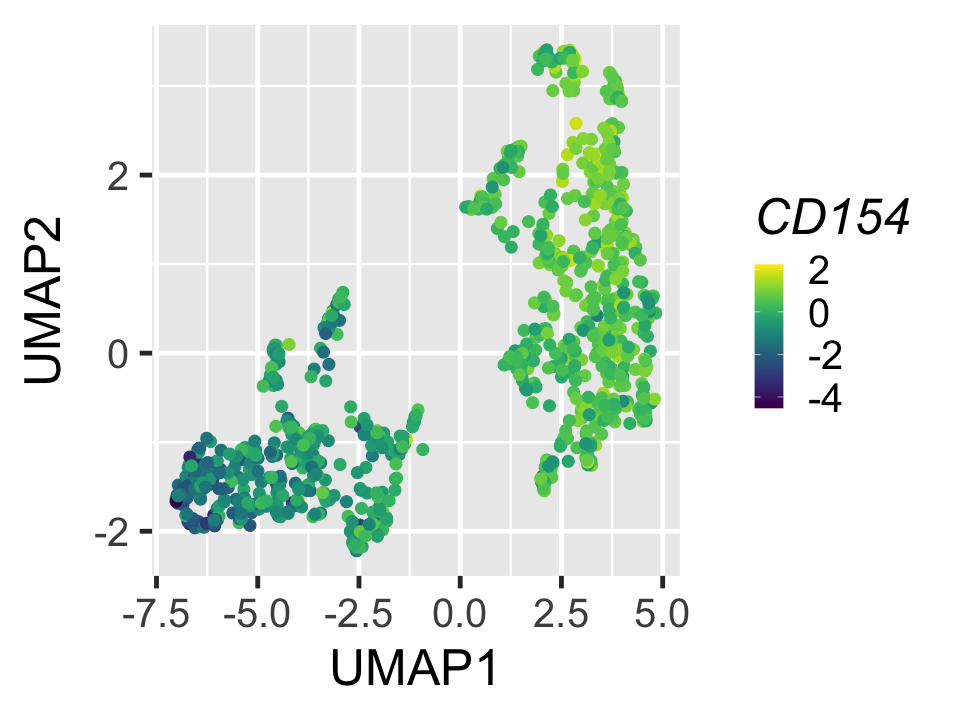

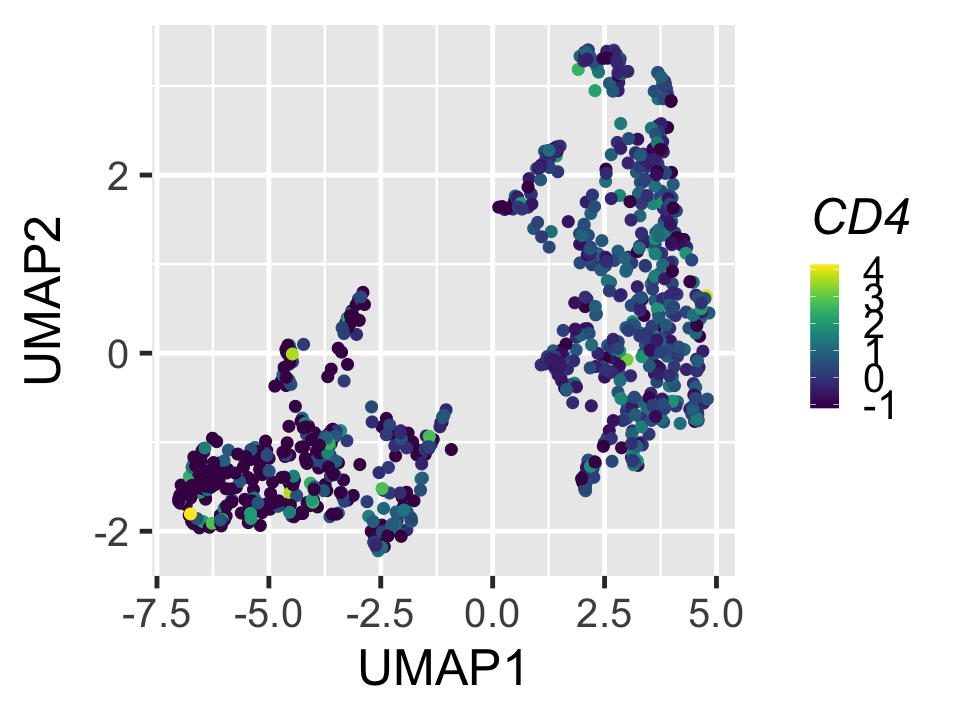

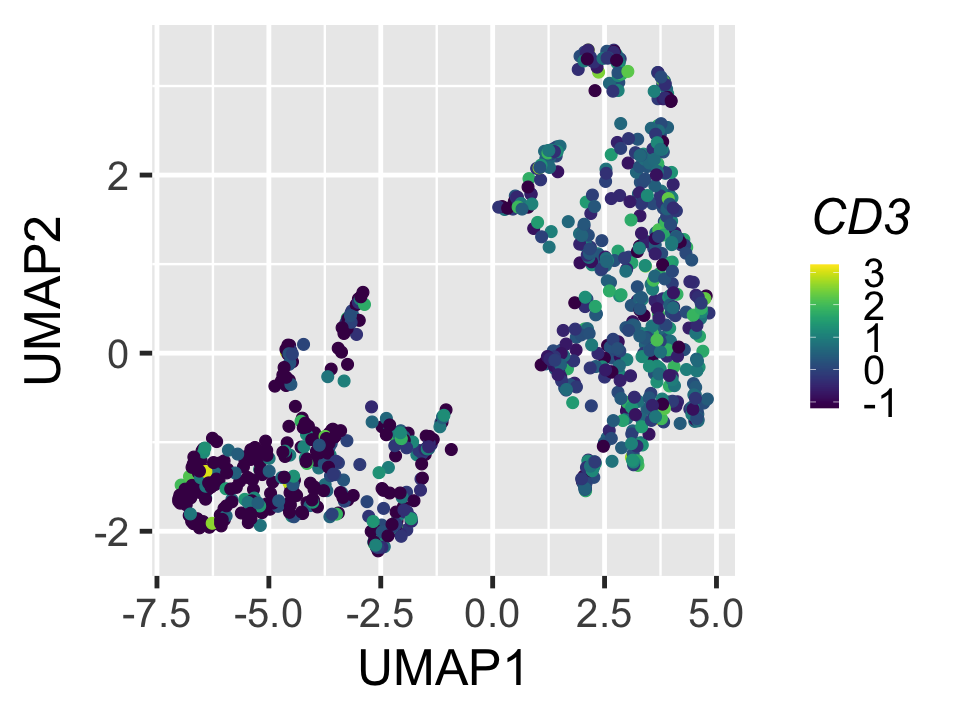

In [117]:
plot_exprs(scale_adt, meta_umap_adt.clust, c("CD154", "CD4", "CD3"))

# Making Figures

In [122]:
##full normalized and scaled expression
filt_norm_scale_exprs <- filt_exprs %>% singlecellmethods::normalizeData(method = "log") %>% 
    singlecellmethods::scaleData()

In [123]:
#normalized expression
norm_exprs <- filt_exprs %>% singlecellmethods::normalizeData(method = "log")

In [124]:
norm_filt_exprs <- norm_exprs %>% t %>% as_tibble(rownames = "cell") 

In [125]:
CLR_adt_filt <- counts_adt_filt%>% singlecellmethods::normalizeData(method = "cellCLR")%>% t %>% 
    as_tibble(rownames = "cell") 

In [231]:
##Merge all three data sets
RPL8Plots <- alleles_DNA_filt_gen %>% inner_join(unique(select(alleles_DNA_filt, cell, plate_well, PlateLabel))) %>%
    inner_join(select(meta_umap_adt.clust, cell, cluster, UMAP1, UMAP2, nUMI)) %>% 
    inner_join(select(meta_umap.clust, cell, cluster, UMAP1, UMAP2, nUMI), by = "cell") %>% 
    mutate("Genotype" = paste0("G",genotype))%>% inner_join(FlowMatrix)

Joining with `by = join_by(plate_well)`
Joining with `by = join_by(cell)`
Joining with `by = join_by(cell)`


In [77]:
#Save meta data files
RPL8Plots %>% write_csv("RPL8Plots.csv")


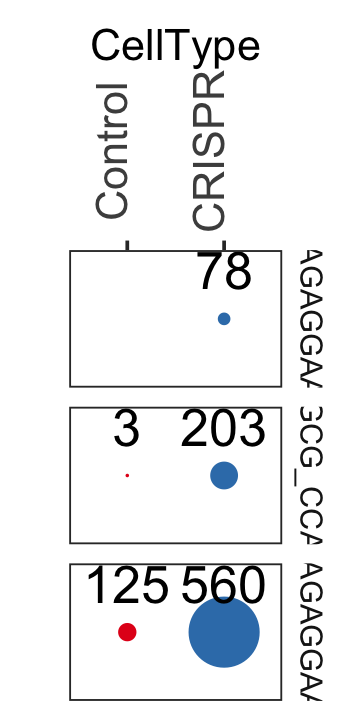

In [233]:
## Plot of PTEN genotypes distributions across RNA clusters
## Define df for plotting 
test2 <- RPL8Plots %>% add_count(genotype,name = "genotype_count") %>% 
    filter(genotype_count  > 2)

#Defineplotting Order
order <- test2$genotype %>% table %>% as_data_frame %>% arrange(`n`)
order <- as.character(order$`.`)


fig.size(6,3)
g <- 

table(test2$genotype,test2$RPL8_Control) %>% 
as.data.frame() %>% dplyr::rename(CellType = Var2, genotype = Var1) %>% 
na.omit %>% filter(Freq != 0) %>% {
    
    ggplot(., aes(CellType,fill=CellType,
                   size = Freq)) +
      geom_point(aes(y = 0),shape = 21, stroke = 0) +
      #geom_hline(yintercept = seq(.5, 4.5, 1), size = .2) +
  scale_x_discrete(position = "top") +
  scale_radius(range = c(1,20)) +
    geom_text(aes(y = 0, label = Freq), size =11, vjust = -0.8)+
  theme_gy() +
  theme(legend.position = "none", 
        panel.grid.major = element_blank(),
        legend.text = element_text(size = 8),
        legend.title = element_text(size = 8), 
       axis.text.x = element_text(angle = 90)) + 
    ylab("") + 
    scale_y_discrete(expand = c(0.1,0.5)) + 
    facet_grid(factor((genotype), levels = order)~ .) + 
    theme(
  strip.background = element_blank(),
  #strip.text.x = element_blank(), 
    #panel.border=element_blank(), 
   # strip.text.y = element_blank()  
        ) +scale_fill_manual(values = c("0"='#8DA0CB',
                                  "CRISPR" = '#377EB8',
                                  "Control"='#E41A1C'))
    
} 
plot(g)
suppressWarnings({ 
    ggsave(g, filename = "RPL8Genotypes.png", device = "png", dpi = 300, width = 3, height = 6)
    })

In [234]:
#Add Dosage
RPL8Plots <- mutate(RPL8Plots, Dosage = ifelse(AllelicGenotype == "A", 2, 
                                                ifelse(AllelicGenotype == "B", 0,
                                                       ifelse(AllelicGenotype == "AB", 1, NA)))) 

# Plotting residuals

In [298]:
df <- filt_exprs["RPL8", ] %>% as_tibble(rownames = "cell") %>% 
    inner_join(RPL8Plots, by ="cell")%>% na.omit()

In [301]:
Regressed <- glm.nb(data= df, 
   value ~ 1+ PlateLabel + log10(nUMI.y))

#Pull residuals and add meta data
Regressed <- resid(Regressed) %>% as_tibble()
colnames(Regressed) <- "Residuals"
Regressed <- cbind(df, Regressed)

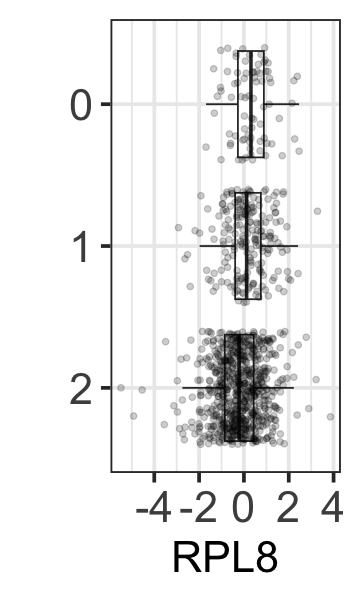

In [304]:
fig.size(5, 3)

Regressed %>%{
ggplot(.) +  
geom_boxplot(outlier.alpha = 0,
             aes(as.factor((Dosage)), `Residuals`)) + 

geom_jitter(aes(as.factor((Dosage)), `Residuals`), 
           alpha = 0.2) + 
theme_gy()+
scale_x_discrete(limits = c("2","1","0")) + 

xlab("") + 
ylab("RPL8")+ 
theme(
     # axis.title.y = element_text(face = "italic"),
    legend.position = "none") 
    } + coord_flip() + 
    theme(strip.text = element_blank())

Joining with `by = join_by(cell)`


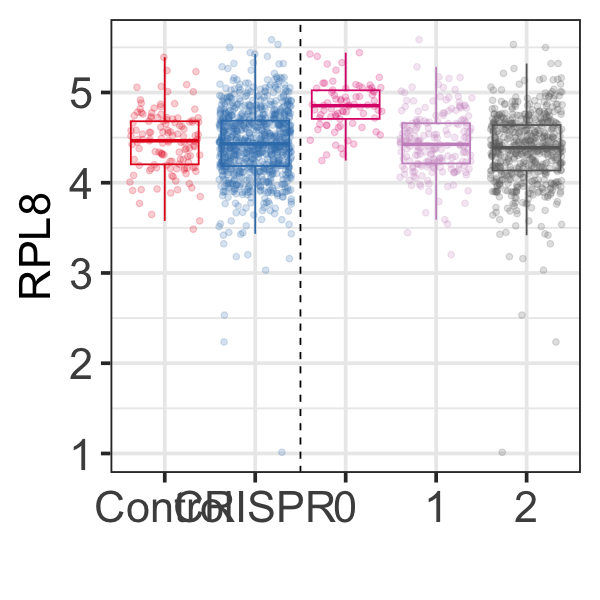

In [241]:
fig.size(5,5)

df <- norm_exprs["RPL8",] %>% as_tibble(rownames = "cell") %>% inner_join(
    RPL8Plots)

ggplot(df) +  
geom_boxplot(outlier.alpha = 0,
             aes(RPL8_Control, `value`, color = RPL8_Control)) + 
geom_boxplot(outlier.alpha = 0, 
             data = filter(df, RPL8_Control != "Control"),
             aes(as.factor(Dosage), `value`, color = as.factor(Dosage))) +
geom_jitter(aes(RPL8_Control, `value`, color = RPL8_Control), 
           alpha = 0.2) + 
geom_jitter(data = filter(df, RPL8_Control != "Control"),
             aes(as.factor(Dosage), `value`, color = as.factor(Dosage)), 
           alpha = 0.2) + 
theme_gy()+
scale_x_discrete(limits = c("Control", 
                           "CRISPR", 
                           "0",
                           "1", 
                           "2"
                           )) + 
geom_vline(xintercept = 2.5, linetype = 2) + 
scale_color_manual(values = c(
              "Control" = "#E41A1C",
              "CRISPR" = "#377EB8",
              "0" = "#DD1C77", 
              "1" = "#C994C7",
              "2" = "grey40"))+ 
xlab("") + 
ylab("RPL8") + 
theme(legend.position = "none")
    

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


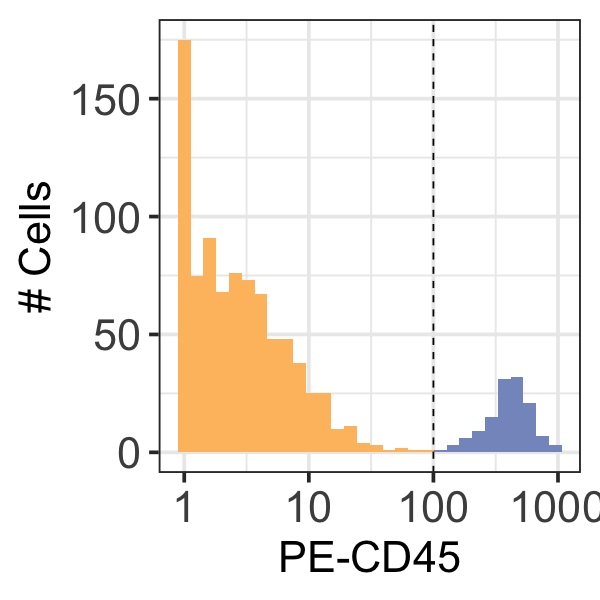

In [243]:
#Flow Gating Plot
fig.size(5, 5)

RPL8Plots %>%
ggplot() +  
geom_histogram(aes(x = PE_CD45, fill = RPL8_Control)) + 
scale_x_log10()+
theme_gy()+
scale_fill_manual(values = c(
          "Control" = "#8698C7",
          "CRISPR" = "#FDBF6E",
          "A/G" = "#C994C7",
          "A/A" = "#DD1C77", 
          "G/G" = "grey"))+   
theme(legend.position = "none") +
geom_vline(xintercept = 100, linetype =2) + 
xlab("PE-CD45") + 
ylab("# Cells")




# Linear Modeling

## Dosage-Dependent

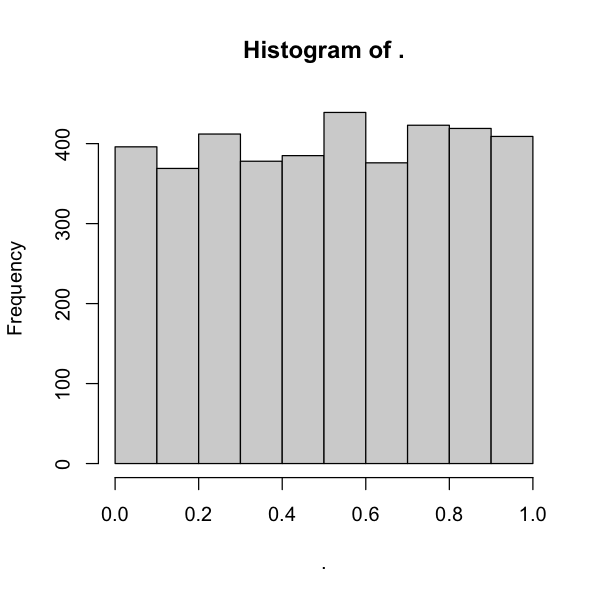

In [247]:
## Linear modeling with negative binomial. 
#filter on gene expression not in the whole data set but only in the selected. 
cells <- RPL8Plots$cell
df <- RPL8Plots %>% filter(RPL8_Control == "CRISPR")
cells <- df$cell

nCells = rowSums(filt_exprs[,cells] > 0)
gene_qc = data.frame(nCells = nCells %>% sort %>% rev, rank = seq(1, length(nCells)))

Exprs <- filt_exprs[gene_qc %>% filter(nCells > length(cells)*0.3) %>% rownames, cells]
genes <- names(which(rowSums(Exprs)/length(cells)> 2))

suppressWarnings({
RPL8_lm <- 
    sapply(genes, function(i){ 
        

    lm0<- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1 + log10(nUMI.y) + PlateLabel
            )
    
    lm1 <- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1  + log10(nUMI.y) + PlateLabel + Dosage
               )
    
    return(c("pval" = anova(lm0,lm1)[2,8],"beta" = summary(lm1)$coeff[8,1]))
        })
    })
RPL8_lm<- RPL8_lm %>% t %>% as_tibble(rownames = "Genes")
RPL8_lm %>% with(pval) %>% hist
RPL8_lm <- RPL8_lm %>% arrange(pval) %>% mutate(padj = p.adjust(pval, method = "BH"))

In [251]:
RPL8_lm %>% write_csv("RPL8_lm_Genotype_Updated.csv")

In [250]:
RPL8_lm %>% filter(padj < 0.05)

Genes pval        beta        padj        
1 RPL8  7.98804e-09 -0.09657483 3.200009e-05

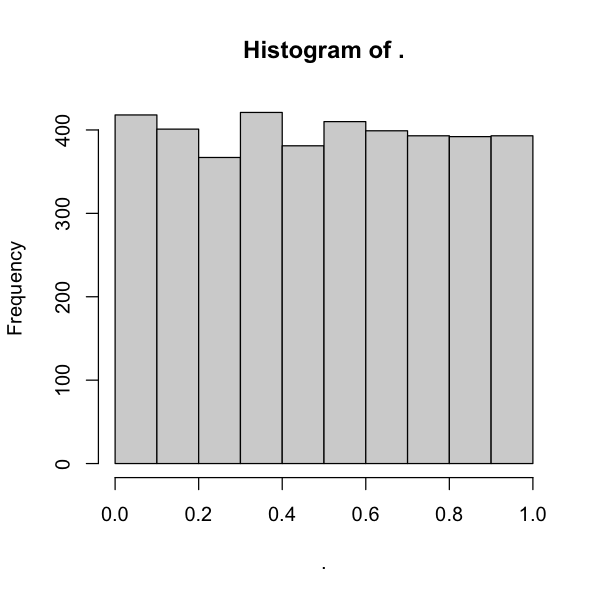

In [257]:
## Linear modeling with negative binomial. 
#filter on gene expression not in the whole data set but only in the selected. 

df <- RPL8Plots 
cells <- df$cell

nCells = rowSums(filt_exprs[,cells] > 0)
gene_qc = data.frame(nCells = nCells %>% sort %>% rev, rank = seq(1, length(nCells)))

Exprs <- filt_exprs[gene_qc %>% filter(nCells > length(cells)*0.3) %>% rownames, cells]
genes <- names(which(rowSums(Exprs)/length(cells)> 2))

suppressWarnings({
RPL8_lm_bulk <- 
    sapply(genes, function(i){ 
        

    lm0<- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1 + log10(nUMI.y) + PlateLabel
            )
    
    lm1 <- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1  + log10(nUMI.y) + PlateLabel + RPL8_Control
               )
    
    return(c("pval" = anova(lm0,lm1)[2,8],"beta" = summary(lm1)$coeff[8,1]))
        })
    })
RPL8_lm_bulk<- RPL8_lm_bulk %>% t %>% as_tibble(rownames = "Genes")
RPL8_lm_bulk %>% with(pval) %>% hist
RPL8_lm_bulk <- RPL8_lm_bulk %>% arrange(pval) %>% mutate(padj = p.adjust(pval, method = "BH"))

In [258]:
RPL8_lm_bulk %>% write_csv("RPL8_lm_bulk_updated.csv")

In [259]:
RPL8_lm_bulk %>% head

Genes  pval         beta        padj      
1 RERE   4.248966e-06  0.71125948 0.01688964
2 FYTTD1 1.696698e-04  0.57623766 0.33721876
3 RPL13  8.785160e-04 -0.08398232 0.70515829
4 CHAF1A 1.153671e-03  0.50609087 0.70515829
5 MICU1  1.213359e-03 -0.71800000 0.70515829
6 RGS10  1.683360e-03  0.87587210 0.70515829

In [261]:
# RPL8 with cluster identify. Interaction?
df <- RPL8Plots 
#df <- df %>% filter(cluster.x == 1) 
lm0<- glm.nb(data = df,
          formula = (Exprs[,df$cell])["RPL8",] ~ 1 + log10(nUMI.y) + PlateLabel + Dosage + cluster.x
            )
    
    lm1 <- glm.nb(data = df, 
          formula = (Exprs[,df$cell])["RPL8",] ~ 1  + log10(nUMI.y) + PlateLabel + Dosage + cluster.x + Dosage*cluster.x)
anova(lm0, lm1)
summary(lm1)
confint(lm1)

Model                                                                   
1 1 + log10(nUMI.y) + PlateLabel + Dosage + cluster.x                     
2 1 + log10(nUMI.y) + PlateLabel + Dosage + cluster.x + Dosage * cluster.x
  theta    Resid. df    2 x log-lik. Test      df LR stat. Pr(Chi)  
1 12.12058 961       -12003.68              NA          NA        NA
2 12.14048 960       -12002.07       1 vs 2  1    1.608559 0.2046945


Call:
glm.nb(formula = (Exprs[, df$cell])["RPL8", ] ~ 1 + log10(nUMI.y) + 
    PlateLabel + Dosage + cluster.x + Dosage * cluster.x, data = df, 
    init.theta = 12.1404821, link = log)

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -4.18453    0.17193 -24.338  < 2e-16 ***
log10(nUMI.y)        2.26422    0.03250  69.666  < 2e-16 ***
PlateLabelRPL8_D_P2 -0.23292    0.03592  -6.485 8.87e-11 ***
PlateLabelRPL8_D_P3 -0.41711    0.04105 -10.160  < 2e-16 ***
PlateLabelRPL8_D_P4  0.01413    0.03736   0.378  0.70531    
PlateLabelRPL8_D_P5 -0.55855    0.03859 -14.473  < 2e-16 ***
PlateLabelRPL8_D_P6 -0.27876    0.04080  -6.832 8.40e-12 ***
Dosage              -0.07133    0.02325  -3.068  0.00215 ** 
cluster.x            0.02114    0.05759   0.367  0.71364    
Dosage:cluster.x    -0.03926    0.03088  -1.271  0.20361    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(12.1405) family

Waiting for profiling to be done...



2.5 %       97.5 %     
(Intercept)         -4.52630545 -3.84244976
log10(nUMI.y)        2.19976164  2.32872218
PlateLabelRPL8_D_P2 -0.30405625 -0.16178717
PlateLabelRPL8_D_P3 -0.49794983 -0.33601219
PlateLabelRPL8_D_P4 -0.05927538  0.08770628
PlateLabelRPL8_D_P5 -0.63462073 -0.48266270
PlateLabelRPL8_D_P6 -0.35903581 -0.19855003
Dosage              -0.11730220 -0.02575198
cluster.x           -0.09164402  0.13375499
Dosage:cluster.x    -0.09987209  0.02140325

Joining with `by = join_by(cell)`
`geom_smooth()` using formula = 'y ~ x'


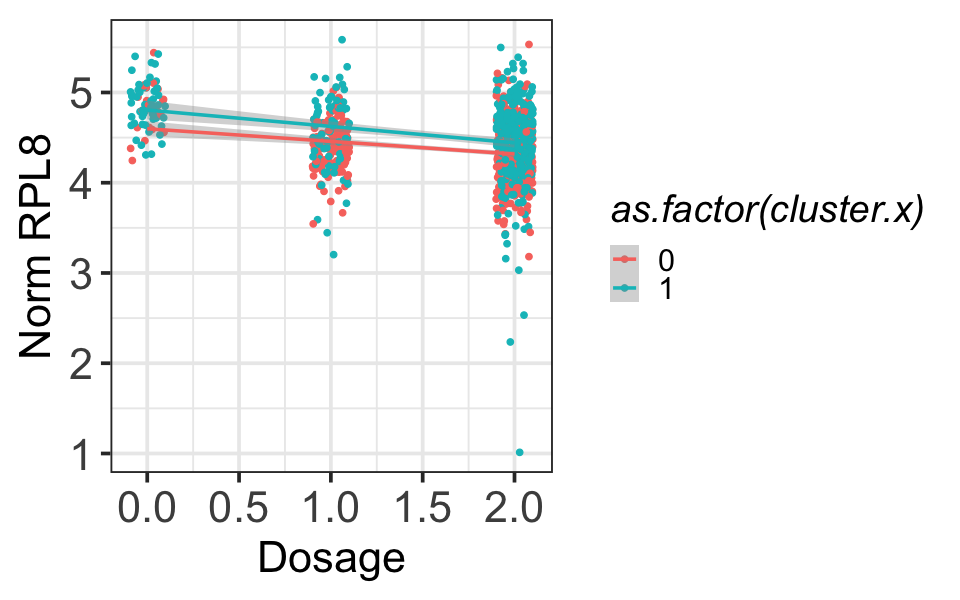

In [287]:
#Plot this
fig.size(5,8)
norm_exprs["RPL8",] %>% as_tibble(rownames = "cell") %>% inner_join(RPL8Plots) %>% 
ggplot(aes(Dosage, value, color = as.factor(cluster.x))) + geom_jitter(width = 0.1) + geom_smooth(method = lm) + theme_minimal() + 
ylab("Norm RPL8") + theme_gy()

In [263]:
anova(lm0, lm1)
summary(lm1)

Model                                                                   
1 1 + log10(nUMI.y) + PlateLabel + Dosage + cluster.x                     
2 1 + log10(nUMI.y) + PlateLabel + Dosage + cluster.x + Dosage * cluster.x
  theta    Resid. df    2 x log-lik. Test      df LR stat. Pr(Chi)  
1 12.12058 961       -12003.68              NA          NA        NA
2 12.14048 960       -12002.07       1 vs 2  1    1.608559 0.2046945


Call:
glm.nb(formula = (Exprs[, df$cell])["RPL8", ] ~ 1 + log10(nUMI.y) + 
    PlateLabel + Dosage + cluster.x + Dosage * cluster.x, data = df, 
    init.theta = 12.1404821, link = log)

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -4.18453    0.17193 -24.338  < 2e-16 ***
log10(nUMI.y)        2.26422    0.03250  69.666  < 2e-16 ***
PlateLabelRPL8_D_P2 -0.23292    0.03592  -6.485 8.87e-11 ***
PlateLabelRPL8_D_P3 -0.41711    0.04105 -10.160  < 2e-16 ***
PlateLabelRPL8_D_P4  0.01413    0.03736   0.378  0.70531    
PlateLabelRPL8_D_P5 -0.55855    0.03859 -14.473  < 2e-16 ***
PlateLabelRPL8_D_P6 -0.27876    0.04080  -6.832 8.40e-12 ***
Dosage              -0.07133    0.02325  -3.068  0.00215 ** 
cluster.x            0.02114    0.05759   0.367  0.71364    
Dosage:cluster.x    -0.03926    0.03088  -1.271  0.20361    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(12.1405) family

In [529]:
# RPL8 with cluster identify
lm0<- glm.nb(data = df,  
          formula = (Exprs)["GPR160",] ~ 1 + log10(nUMI.y) + PlateLabel 
            )
    
    lm1 <- glm.nb(data = df,  
          formula = (Exprs)["GPR160",] ~ 1  + log10(nUMI.y) + PlateLabel + Dosage
               )
    

In [530]:
anova(lm0, lm1)
summary(lm1)

Model                                   theta     Resid. df    2 x log-lik.
1 1 + log10(nUMI.y) + PlateLabel          0.7668655 765       -2320.578      
2 1 + log10(nUMI.y) + PlateLabel + Dosage 0.8198369 764       -2297.119      
  Test      df LR stat. Pr(Chi)     
1        NA          NA           NA
2 1 vs 2  1    23.45915 1.275945e-06


Call:
glm.nb(formula = (Exprs)["GPR160", ] ~ 1 + log10(nUMI.y) + PlateLabel + 
    Dosage, data = df, init.theta = 0.819836901, link = log)

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)          -9.7385     1.1019  -8.838  < 2e-16 ***
log10(nUMI.y)         2.2293     0.1817  12.267  < 2e-16 ***
PlateLabelRPL8_D_P2   0.2258     0.6162   0.366    0.714    
PlateLabelRPL8_D_P3   0.2487     0.6174   0.403    0.687    
PlateLabelRPL8_D_P4  -0.1546     0.6394  -0.242    0.809    
PlateLabelRPL8_D_P5   0.3176     0.6036   0.526    0.599    
PlateLabelRPL8_D_P6  -0.2100     0.6065  -0.346    0.729    
Dosage               -0.5061     0.1037  -4.879 1.07e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(0.8198) family taken to be 1)

    Null deviance: 1011.58  on 771  degrees of freedom
Residual deviance:  703.48  on 764  degrees of freedom
AIC: 2315.1

Number of Fisher Scoring iter

# ADT modeling

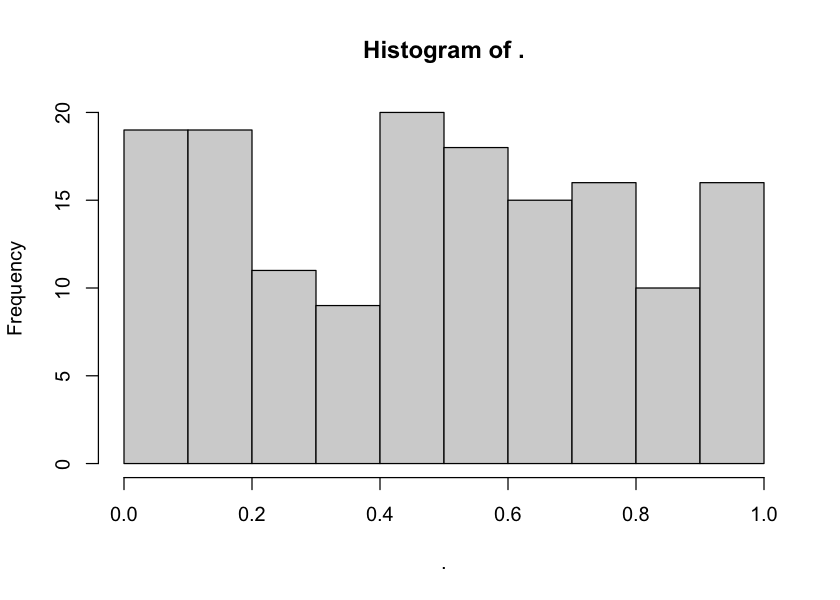

In [267]:
## Linear modeling with negative binomial. 
#filter on gene expression not in the whole data set but only in the selected. 
df <- RPL8Plots %>% filter(RPL8_Control == "CRISPR")
cells <- df$cell

Exprs <- counts_adt_filt[,cells]
genes <- rownames(Exprs)


suppressWarnings({
RPL8_lm_adt <- 
    sapply(genes[genes != "Ig_L" ], function(i){ 
        
    lm0<- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1 + log10(nUMI.x) + PlateLabel
            )
    
    lm1 <- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1  + log10(nUMI.x) + PlateLabel + Dosage
               )
    
    return(c("pval" = anova(lm0,lm1)[2,8],"beta" = summary(lm1)$coeff[8,1]))
        })
    })
RPL8_lm_adt<- RPL8_lm_adt %>% t %>% as_tibble(rownames = "Genes")
RPL8_lm_adt %>% with(pval) %>% hist
RPL8_lm_adt <- RPL8_lm_adt %>% arrange(pval) %>% mutate(padj = p.adjust(pval, method = "BH"))

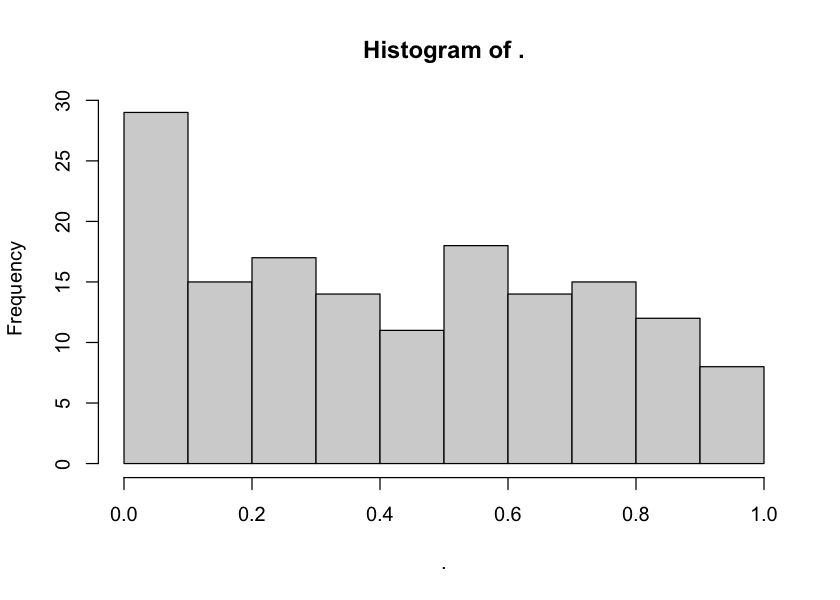

In [268]:
## Linear modeling with negative binomial. 
#filter on gene expression not in the whole data set but only in the selected. 
df <- RPL8Plots
cells <- df$cell

Exprs <- counts_adt_filt[,cells]
genes <- rownames(Exprs)


suppressWarnings({
RPL8_lm_adt_Condition <- 
    sapply(genes[genes != "Ig_L" ], function(i){ 
        
    lm0<- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1 + log10(nUMI.x) + PlateLabel
            )
    
    lm1 <- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1  + log10(nUMI.x) + PlateLabel + RPL8_Control
               )
    
    return(c("pval" = anova(lm0,lm1)[2,8],"beta" = summary(lm1)$coeff[8,1]))
        })
    })
RPL8_lm_adt_Condition<- RPL8_lm_adt_Condition %>% t %>% as_tibble(rownames = "Genes")
RPL8_lm_adt_Condition %>% with(pval) %>% hist
RPL8_lm_adt_Condition <- RPL8_lm_adt_Condition %>% arrange(pval) %>% mutate(padj = p.adjust(pval, method = "BH"))

In [270]:
RPL8_lm_adt %>% filter(padj < 0.05)
RPL8_lm_adt_Condition%>% filter(padj < 0.05)


Genes pval         beta       padj        
1 CD127 6.199323e-06 -0.1904487 0.0009484964

Genes            pval         beta       padj      
1 CD57_Recombinant 7.376393e-05 -0.2609895 0.01128588

In [316]:
RPL8_lm

Genes     pval         beta          padj        
1    RPL8      7.988040e-09 -0.09657483   3.200009e-05
2    RPS29     6.126448e-05 -0.12679380   8.745352e-02
3    NIBAN3    7.145037e-05 -0.47517780   8.745352e-02
4    DNM2      8.732253e-05  0.19721653   8.745352e-02
5    RNF113A   1.628153e-04  0.62985200   1.304476e-01
6    UBE2J2    2.201894e-04  0.33589125   1.470131e-01
7    PPA1      6.794899e-04 -0.15578946   3.592075e-01
8    INTS6-AS1 7.173389e-04 -0.24222308   3.592075e-01
9    INO80E    1.123459e-03 -0.27662678   4.763683e-01
10   MRPL47    1.511974e-03 -0.29620386   4.763683e-01
11   SPG21     1.555334e-03 -0.21516328   4.763683e-01
12   IK        1.645307e-03  0.33958986   4.763683e-01
13   STT3A     1.700482e-03  0.26436490   4.763683e-01
14   ARIH2     1.800542e-03  0.22134260   4.763683e-01
15   OSBPL10   1.894751e-03 -0.31296337   4.763683e-01
16   FBXL15    1.902619e-03  0.55052523   4.763683e-01
17   AGBL3     2.097893e-03 -0.28091011   4.943623e-01
18   MAP2K1    2.294256e-03 -0.33864463   5.105994e-01
19   MITD1     2.565711e-03 -0.27140015   5.409599e-01
20   SPR       3.258868e-03 -0.35186748   6.223824e-01
21   SF3B4     3.262614e-03  0.17608709   6.223824e-01
22   MRPL52    3.921492e-03 -0.18116478   7.140681e-01
23   PDE4D     4.493713e-03 -0.30028674   7.557872e-01
24   TAX1BP1   4.527931e-03  0.36705852   7.557872e-01
25   CHST12    4.933448e-03  0.32810060   7.891601e-01
26   UQCRH     5.277514e-03 -0.12451473   7.891601e-01
27   CD55      5.359511e-03 -0.45735420   7.891601e-01
28   EIF2D     5.748127e-03  0.26638679   7.891601e-01
29   HIKESHI   6.119039e-03  0.28751052   7.891601e-01
30   SRSF8     6.978226e-03  0.22985758   7.891601e-01
⋮    ⋮         ⋮            ⋮             ⋮           
3977 PMVK      0.9929986    -8.879663e-04 0.9990248   
3978 SH3BP5    0.9931265     1.284458e-03 0.9990248   
3979 TACO1     0.9931587    -1.192481e-03 0.9990248   
3980 CMC1      0.9932756    -6.740151e-04 0.9990248   
3981 GRK6      0.9937476     8.646837e-04 0.9990248   
3982 COQ9      0.9938631     1.015567e-03 0.9990248   
3983 POLR1D    0.9940975     4.662080e-04 0.9990248   
3984 CDC45     0.9942546    -8.251646e-04 0.9990248   
3985 DAZAP1    0.9943413     4.173639e-04 0.9990248   
3986 MCRIP1    0.9944577     8.391213e-04 0.9990248   
3987 FAF1      0.9945043    -6.543399e-04 0.9990248   
3988 NAA25     0.9947797    -9.070978e-04 0.9990248   
3989 TACC3     0.9947853     6.104830e-04 0.9990248   
3990 NACA      0.9955083    -1.394982e-04 0.9992304   
3991 CNDP2     0.9957098    -4.580710e-04 0.9992304   
3992 COX6C     0.9957383    -1.890578e-04 0.9992304   
3993 MAP4      0.9961329    -6.588315e-04 0.9993760   
3994 PPP1R2    0.9967204    -3.627226e-04 0.9994012   
3995 ZMAT2     0.9970026    -4.823251e-04 0.9994012   
3996 RIOK1     0.9973200     2.881891e-04 0.9994012   
3997 GGH       0.9974334     4.447147e-04 0.9994012   
3998 PSMB8     0.9976737    -1.144384e-04 0.9994012   
3999 EPC1      0.9978946    -2.384843e-04 0.9994012   
4000 PTTG1     0.9979043    -2.321014e-04 0.9994012   
4001 CCNI      0.9983139    -1.246106e-04 0.9995029   
4002 BLOC1S1   0.9987333     9.327123e-05 0.9995029   
4003 SMNDC1    0.9987544     2.077387e-04 0.9995029   
4004 TLN1      0.9992011     1.237489e-04 0.9997002   
4005 PRMT5     0.9997476    -2.772630e-05 0.9998220   
4006 MAP2K3    0.9998220    -2.539587e-05 0.9998220

## Linking Genes to Locations for the Purposes of creating a manhattan plot

In [271]:
gtf <- read_tsv("mart_export.tsv")

Rows: 276950 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (6): Gene stable ID, Transcript stable ID, Transcript name, Protein stab...
dbl (3): Gene start (bp), Gene end (bp), Strand

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [272]:
colnames(gtf) <- c("geneID", "transcriptID", "Start", "End", "TranscriptName", "ProteinID", "Strand", "Chr", "Genes")

In [273]:
gtf_filt <- gtf %>% dplyr::select(Genes, Start, Chr) %>% unique

In [274]:
manh <- RPL8_lm %>% inner_join(gtf_filt)
manh<- manh %>% filter(Chr %in% 1:24) %>% mutate(Chr = as.numeric(Chr)) 
### do it with ggplot damnit
## filter out non numeric Chr
don <- manh %>% 
  
  # Compute chromosome size
  group_by(Chr) %>% 
  summarise(chr_len=max(Start)) %>% 
  
  # Calculate cumulative position of each chromosome
  mutate(tot=cumsum(chr_len)-chr_len) %>%
  dplyr::select(-chr_len) %>%
  
  # Add this info to the initial dataset
  left_join(manh, ., by=c("Chr"="Chr")) %>%
  
  # Add a cumulative position of each SNP
  arrange(Chr, Start) %>%
  mutate( BPcum=Start+tot)

Joining with `by = join_by(Genes)`


In [275]:
#prepare the xaxis 
axisdf = don %>% group_by(Chr) %>% summarize(center=( max(BPcum) + min(BPcum) ) / 2 )


In [276]:
brewer.pal(n = 3, "Set2")

[1] "#66C2A5" "#FC8D62" "#8DA0CB"

In [281]:
don

Genes    pval         beta         padj      Start    Chr tot       
1    NOC2L    0.0410412335 -0.12839965  0.9180795  944203  1   0         
2    ISG15    0.0129017191  0.28772280  0.7898311 1001138  1   0         
3    SDF4     0.7431288717 -0.02695801  0.9980847 1216931  1   0         
4    B3GALT6  0.2627995278 -0.15837480  0.9980847 1232237  1   0         
5    UBE2J2   0.0002201894  0.33589125  0.1470131 1253909  1   0         
6    PUSL1    0.1699373678 -0.22435408  0.9980847 1308597  1   0         
7    INTS11   0.3021280687 -0.10326411  0.9980847 1311585  1   0         
8    CPTP     0.8987239961 -0.01112937  0.9987079 1324756  1   0         
9    AURKAIP1 0.2428970570  0.05569564  0.9980847 1373730  1   0         
10   CCNL2    0.3553176121 -0.07551903  0.9980847 1385711  1   0         
11   MRPL20   0.0407986533  0.09734322  0.9180795 1401909  1   0         
12   SSU72    0.1304120065  0.08293614  0.9980847 1541673  1   0         
13   NADK     0.7196545202 -0.03403540  0.9980847 1751232  1   0         
14   GNB1     0.1203835812  0.16563311  0.9980847 1785285  1   0         
15   RER1     0.3578145118 -0.08187257  0.9980847 2391775  1   0         
16   WRAP73   0.6055883804 -0.06630421  0.9980847 3630767  1   0         
17   LRRC47   0.1103563522  0.20739054  0.9980847 3778559  1   0         
18   KCNAB2   0.2131439103 -0.12762878  0.9980847 5990927  1   0         
19   RPL22    0.1607184795 -0.06133024  0.9980847 6185020  1   0         
20   ICMT     0.3895261776 -0.10897073  0.9980847 6221193  1   0         
21   ACOT7    0.9554188897  0.00637811  0.9988028 6264269  1   0         
22   NOL9     0.1047224232 -0.25841379  0.9980847 6521347  1   0         
23   ZBTB48   0.5318968290 -0.09060200  0.9980847 6579994  1   0         
24   DNAJC11  0.5200831017  0.05186925  0.9980847 6634168  1   0         
25   CAMTA1   0.5792364921 -0.03735879  0.9980847 6785454  1   0         
26   PARK7    0.2180794434 -0.05515839  0.9980847 7954291  1   0         
27   RERE     0.1470058176  0.12145866  0.9980847 8352397  1   0         
28   ENO1     0.7748627706 -0.00805225  0.9980847 8861000  1   0         
29   SLC2A5   0.6461806848 -0.04260620  0.9980847 9035106  1   0         
30   SLC25A33 0.6249926015 -0.04965631  0.9980847 9539465  1   0         
⋮    ⋮        ⋮            ⋮            ⋮         ⋮        ⋮   ⋮         
3739 POLR3H   0.01731375    0.274325968 0.8063090 41525799 22  2811804980
3740 DESI1    0.23710436    0.123826433 0.9980847 41598028 22  2811804980
3741 XRCC6    0.86740546    0.010077393 0.9980847 41621163 22  2811804980
3742 SNU13    0.27557908    0.048672032 0.9980847 41673933 22  2811804980
3743 SREBF2   0.56712011   -0.054275760 0.9980847 41833105 22  2811804980
3744 CENPM    0.66255312    0.034897844 0.9980847 41938737 22  2811804980
3745 SMDT1    0.45777147    0.039762778 0.9980847 42079691 22  2811804980
3746 NDUFA6   0.70454690    0.024181761 0.9980847 42085526 22  2811804980
3747 RRP7A    0.29607329    0.059834160 0.9980847 42508344 22  2811804980
3748 POLDIP3  0.82875425    0.018755492 0.9980847 42583721 22  2811804980
3749 CYB5R3   0.67664263    0.037587363 0.9980847 42615730 22  2811804980
3750 MCAT     0.98194186    0.003120772 0.9988028 43132209 22  2811804980
3751 TTLL12   0.98678762    0.001353459 0.9988028 43166622 22  2811804980
3752 SAMM50   0.34057809    0.087488816 0.9980847 43955442 22  2811804980
3753 NUP50-DT 0.14796870   -0.063913790 0.9980847 45133020 22  2811804980
3754 FAM118A  0.70309522    0.050192513 0.9980847 45308968 22  2811804980
3755 ATXN10   0.32865342    0.056441130 0.9980847 45671798 22  2811804980
3756 GTSE1    0.20976784   -0.191678283 0.9980847 46296870 22  2811804980
3757 TRMU     0.86652826   -0.021580587 0.9980847 46330875 22  2811804980
3758 TBC1D22A 0.11258389   -0.209110950 0.9980847 46762617 22  2811804980
3759 CRELD2   0.42851022   -0.114094246 0.9980847 49918167 22  2811804980
3760 PIM3     0.75815761   -0.024004311 0.9980847 49960768 22  2811804980
3761 TRAB

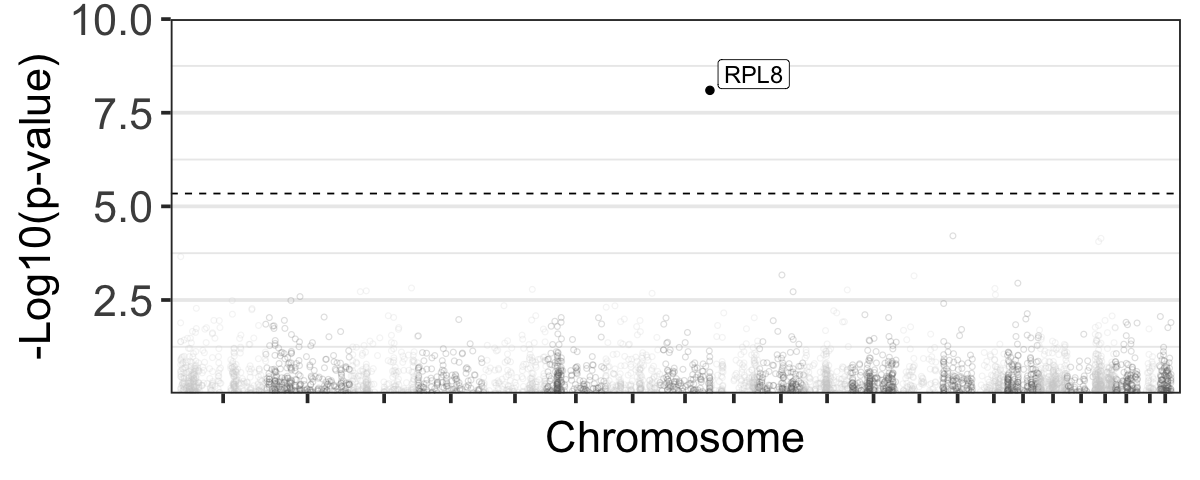

In [283]:
#define colors
colors = rep(c("grey80", "grey40"), 11 )
names(colors) = as.character(1:22)

fig.size(4,10)
g <- don %>% 
{
ggplot(., aes(x=BPcum, y=-log10(pval))) +
    
    # Show all points
    geom_point( aes(color=as.factor(Chr)), alpha=0.2, size=1.3, shape = 1) +
    scale_color_manual(values = c(colors, 
                                    "HH" = "#66C2A5", 
                                    "Daudi" = "#FC8D62"))+
    
    # custom X axis:
    scale_x_continuous(expand = c(0.01,0.01),label = axisdf$Chr, breaks= axisdf$center ) +
    scale_y_continuous(expand = c(0, 0), limits = c(NA, -log10(10^-10))) +     # remove space between plot area and x axis
  
    # Custom the theme:
    theme_gy() +
    theme(axis.text.x =element_text(size =0, vjust = 0.5, angle = -90),
      legend.position="none",
      panel.grid.major.x = element_blank(),
      panel.grid.minor.x = element_blank()
    ) + 
    geom_label_repel(data = filter(., pval < 0.05/6136), 
                     aes(label = Genes), size=5) + 

    geom_point(data = filter(., pval < 0.05/6136), size=2, ) +
geom_hline(yintercept = -log10(0.05/11000), linetype = 2)+
xlab("Chromosome") + 
ylab("-Log10(p-value)")
    }
plot(g)
suppressWarnings({ggsave(g, filename = "Man.png", device="png", width = 10, height = 4) })

In [242]:
RPL8Plots %>% colnames

[1] "DNA_Barcode"    "Well_ID"        "Alleles"        "Reference"     
 [5] "genotype"       "PlateLabel"     "Condition"      "RNA_Barcode"   
 [9] "ADT_Barcode"    "sgRNA_Sequence" "ExpectedChange" "Read"          
[13] "RNA_cell"       "cell"           "Dosage"         "Dosage2"       
[17] "cluster.x"      "UMAP1.x"        "UMAP2.x"        "nUMI.x"        
[21] "cluster.y"      "UMAP1.y"        "UMAP2.y"        "nUMI.y"        
[25] "Genotype"       "FSC"            "SSC"            "PE_CD45"       
[29] "RPL8_Control"

Joining with `by = join_by(cell)`
Joining with `by = join_by(cell)`


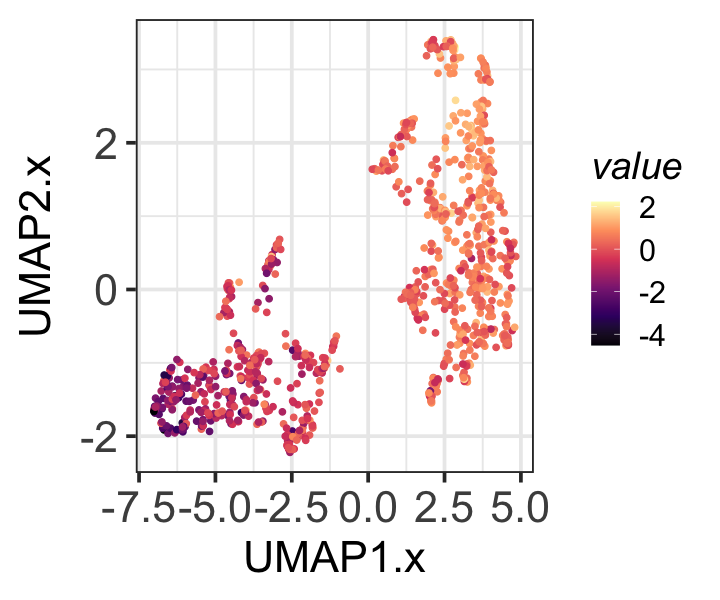

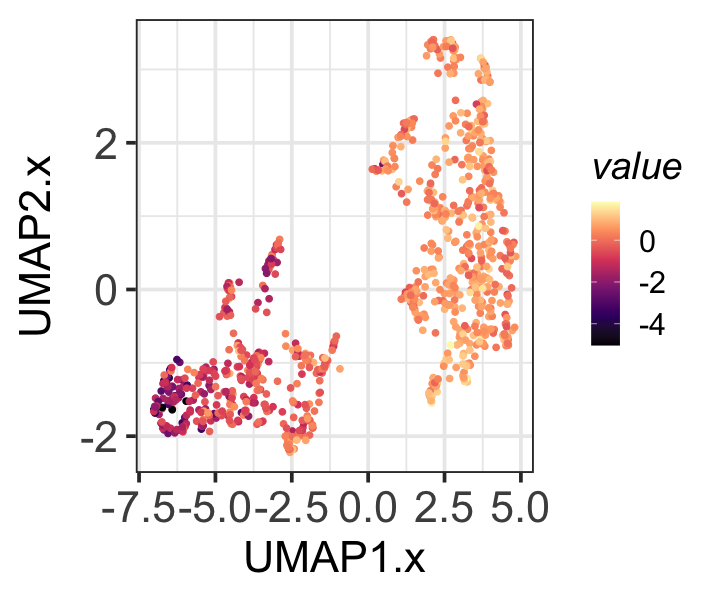

In [284]:
fig.size(5,6)
scale_adt["CD154",] %>% as_tibble(rownames = "cell") %>% 
inner_join(RPL8Plots) %>% { 
ggplot(., aes(UMAP1.x, UMAP2.x, color = value)) + geom_point() + theme_gy() + scale_color_viridis_c(option = "magma")
}
scale_adt["CD150",] %>% as_tibble(rownames = "cell") %>% 
inner_join(RPL8Plots) %>% { 
ggplot(., aes(UMAP1.x, UMAP2.x, color = value)) + geom_point() + theme_gy() + scale_color_viridis_c(option = "magma")
}


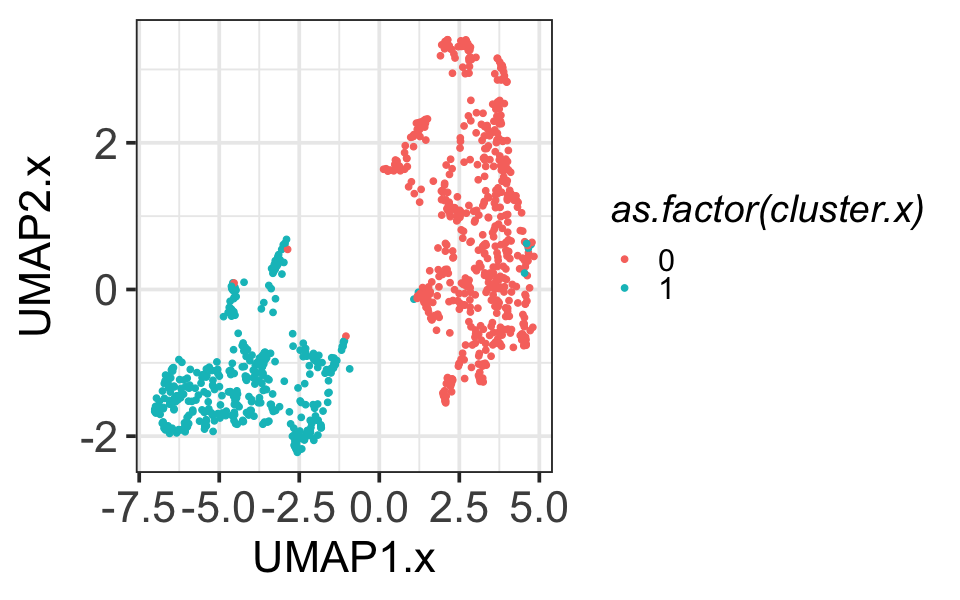

In [291]:
#Supplementary Plot
(RPL8Plots) %>% { 
ggplot(., aes(UMAP1.x, UMAP2.x, color = as.factor(cluster.x))) + geom_point() + theme_gy() #+ scale_color_viridis_c(option = "magma")
}

In [294]:
alleles_DNA_filt %>% Plotting_Alleles %>% ggsave(filename = "RPL8alleles.png")

Saving 7 x 7 in image
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“Unable to calculate text width/height (using zero)”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“Unable to calculate text width/height (using zero)”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“Unable to calculate text width/height (using zero)”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“Unable to calculate text width/height (using zero)”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“Unable to calculate text width/height (using zero)”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“Unable to calculate text width/height (using zero)”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“Unable to calculate text width/height (using zero)”
Warning message in grid.Call(C_te

# QC numbers

In [2]:
library(tidyverse)

── Attaching core tidyverse packages ───────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [9]:
read_csv("RPL8Plots_updated.csv") %>% select(
    cell, PlateLabel, nUMI.x, nUMI.y, genotype, AllelicGenotype, Dosage, cluster.x, cluster.y, RPL8_Control) %>% 
inner_join(select(read_csv("filt_meta_rna.csv"), cell, nGenes)) %>% 
inner_join(select(read_csv("filt_meta_adt.csv"), cell, nGenes), by ="cell") %>% write_csv("RPL8meta.csv")

Rows: 970 Columns: 19
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (7): plate_well, genotype, AllelicGenotype, cell, PlateLabel, Genotype,...
dbl (12): Dosage, cluster.x, UMAP1.x, UMAP2.x, nUMI.x, cluster.y, UMAP1.y, U...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 2064 Columns: 15
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (12): ...1, plate, cell, PlateLabel, Condition, DNA_Barcode, ADT_Barcode...
dbl  (3): nUMI, nGenes, pctMito

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(cell)`
New names:
• ``

In [313]:
filt_meta_adt%>% select(PlateLabel) %>% table

PlateLabel
RPL8_D_P1 RPL8_D_P2 RPL8_D_P3 RPL8_D_P4 RPL8_D_P5 RPL8_D_P6 
      311       324       341       332       350       350 

In [312]:
filt_meta %>% select(PlateLabel) %>% table

PlateLabel
RPL8_D_P1 RPL8_D_P2 RPL8_D_P3 RPL8_D_P4 RPL8_D_P5 RPL8_D_P6 
      363       325       342       334       350       350 

In [314]:
alleles_DNA_filt %>% select(PlateLabel) %>% table

PlateLabel
RPL8_D_P1 RPL8_D_P2 RPL8_D_P3 RPL8_D_P4 RPL8_D_P5 RPL8_D_P6 
      224       248       155       153       319       214 

In [315]:
RPL8Plots  %>% select(PlateLabel) %>% table

PlateLabel
RPL8_D_P1 RPL8_D_P2 RPL8_D_P3 RPL8_D_P4 RPL8_D_P5 RPL8_D_P6 
      160       164       107       135       235       169 